# _Moneyballing Fantasy Premier League Football_
# Expected Goals

A common statistic in football analysis is 'Expected Goals'. This talks to the idea that, sometimes, football games are subject to flukes and random chance. A striker could have 20 shots on target, which in one game could result in 5 goals, and in another could result in none (if they were unlucky with woodwork, or if the opposition goalkeeper was in very good form).

The idea of expected goals is to look at the characteristics of a shot, and assign a probability that this shot would result in a goal (e.g. a header from the centre of the 6 yard box might typically result in a goal 50% of the time, whereas a speculative effort from a difficult angle might only be a goal 10% of the time.

By summing all the probabilities across a player's shots in a game, we can calculate how many goals we would expect a player to score in a given match (we can also take the converse of this, and calculate the total expected goals conceded for a team).

### Bringing in the required libraries...

In [1]:
#Standard data manipulations
import pandas as pd
import numpy as np
import itertools

#SQL
import sqlite3
#Including custom functions, stored elsewhere in the repo
from PythonFunctions.sqlfunctions import *

#Webscraping libraries
from splinter import Browser
from bs4 import BeautifulSoup
from datetime import datetime, date
import time

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import custom visuals settings
from PythonFunctions.cb91visuals import *

#Linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Pickle!
import pickle

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

### ...and the data

In [2]:
#Connect to the database 'fpl.db' (fantasy premier league!)
conn = sqlite3.connect('Data/fpl.db')
#Instantiate a cursor
c = conn.cursor()

## Fixtures Table

We will thank ourselves later if we create a table of upcoming fixtures. This will allow us to more easily call on matches in specific gameweeks, when we are trying to make our predictions.

In [3]:
#Firstly create a browser for splinter to go through
executable_path = {"executable_path": "/Users/Callum/Downloads/geckodriver"}

#Uncomment below to initiate browser
# browser = Browser("firefox", **executable_path, headless=False)

Create some functions that will get basic fixture details for the season.

In [4]:
def fixture_detail(match, pause=2):
    '''
    Takes a match code and returns a single row datafrmae showing
    the match id, the date, the gameweek, and the home and away teams
    '''
    
    #Send the splinter instance of the URL
    match_url = f'https://www.premierleague.com/match/{match}'
    browser.visit(match_url)
    #Let it load!
    time.sleep(3)

    
    #Get the HTML
    html = BeautifulSoup(browser.html, 'html.parser')
    
    #Get the date of the match
    try:
        date_html = html.findAll('div',class_='matchDate')[0].get_text()
        date = datetime.strptime(date_html, '%a %d %b %Y').strftime("%Y-%m-%d")
    except:
        date = 'TBC'
    
    #Get the gameweek
    gameweek = html.findAll('div',class_='long')[0].get_text().replace('Matchweek ','')
    
    #Get the home and away teams
    home = html.findAll('div',class_='team home')[0].findAll(
        'span',class_='long')[0].get_text()
    away = html.findAll('div',class_='team away')[0].findAll(
        'span',class_='long')[0].get_text()
    
    columns = ['MatchID','GameWeek','Date','HomeTeam','AwayTeam']
    
    return pd.DataFrame({'MatchID':[match],
            'GameWeek':[gameweek],
            'Date':[date],
            'HomeTeam':[home],
            'AwayTeam':[away]}, columns = columns)

def fixture_details(matches):
    '''
    Takes a list of match codes and returns a dataframe showing
    the match id, the date, the gameweek, and the home and away teams    
    '''
    
    #Instantiate a dataframe
    columns = ['MatchID','GameWeek','Date','HomeTeam','AwayTeam']
    temp_df = pd.DataFrame(columns=columns)
    
    for i in matches:
        try:
            new_row = fixture_detail(i)
            temp_df = pd.concat([temp_df, new_row])
        except:
            pass
        
    return temp_df
        

We comment out the below having done it once...

In [5]:
# df_fixtures = fixture_details(list(range(46605,46985)))
# df_fixtures.reset_index(inplace=True, drop=True)

# Let's pickle this so we don't need to run it again...
# with open('Data/df_fixtures.pickle', 'wb') as f:
#     pickle.dump(df_fixtures, f, pickle.HIGHEST_PROTOCOL)

In [6]:
# And opening the pickle...   
with open('Data/df_fixtures.pickle', 'rb') as f:
    df_fixtures = pickle.load(f)
    
df_fixtures['Date'] = df_fixtures['Date'].astype('str')
df_fixtures.reset_index(inplace=True, drop=True)

And upload the lot to our SQL database, again commenting out when we've already done it once...

In [7]:
create_sql_table(df_fixtures, c, table_name = 'FixturesBasic', verbose=True)
conn.commit()

populate_sql_from_dataframe(df_fixtures, 'FixturesBasic', c, verbose=True)
conn.commit()

CREATE TABLE FixturesBasic (FixturesBasicID INTEGER PRIMARY KEY, TableIndex TEXT, MatchID TEXT, GameWeek INTEGER, Date TEXT, HomeTeam TEXT, AwayTeam TEXT, unique (MatchID, GameWeek, Date, HomeTeam, AwayTeam));

Table not added - possibly already exists
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (0, "46605", 1, "2019-08-09", "Liverpool", "Norwich City");
                       
Error on row 0 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (1, "46606", 1, "2019-08-10", "Bournemouth", "Sheffield United");
                       
Error on row 1 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (2, "46607", 1, "2019-08-10", "Burnley", "Southampton");
                       
Error on row 2 - you may be 

Error on row 77 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (78, "46683", 8, "2019-10-05", "Watford", "Sheffield United");
                       
Error on row 78 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (79, "46684", 8, "2019-10-05", "West Ham United", "Crystal Palace");
                       
Error on row 79 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (80, "46685", 9, "2019-10-19", "Aston Villa", "Brighton and Hove Albion");
                       
Error on row 80 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (81, "46686", 9, 

Error on row 150 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (151, "46756", 16, "2019-12-07", "Bournemouth", "Liverpool");
                       
Error on row 151 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (152, "46757", 16, "2019-12-08", "Brighton and Hove Albion", "Wolverhampton Wanderers");
                       
Error on row 152 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (153, "46758", 16, "2019-12-07", "Everton", "Chelsea");
                       
Error on row 153 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (154, "46759"

Error on row 229 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (230, "46835", 24, "2020-01-21", "Aston Villa", "Watford");
                       
Error on row 230 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (231, "46836", 24, "2020-01-21", "Bournemouth", "Brighton and Hove Albion");
                       
Error on row 231 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (232, "46837", 24, "2020-01-21", "Everton", "Newcastle United");
                       
Error on row 232 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (233, "46838", 24,

                       
Error on row 299 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (300, "46905", 31, "2020-03-21", "Burnley", "Watford");
                       
Error on row 300 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (301, "46906", 31, "2020-03-21", "Chelsea", "Manchester City");
                       
Error on row 301 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (302, "46907", 31, "2020-03-22", "Leicester City", "Brighton and Hove Albion");
                       
Error on row 302 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VAL

Error on row 330 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (331, "46936", 34, "2020-04-19", "Aston Villa", "Manchester United");
                       
Error on row 331 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (332, "46937", 34, "2020-04-18", "Bournemouth", "Tottenham Hotspur");
                       
Error on row 332 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (333, "46938", 34, "2020-04-20", "Brighton and Hove Albion", "Liverpool");
                       
Error on row 333 - you may be trying to upload a duplicate row
INSERT INTO FixturesBasic (TableIndex, MatchID, GameWeek, Date, HomeTeam, AwayTeam)
                       VALUES (334,

Let's bring the dataframe in from the SQL database.

In [8]:
df_fixtures = sql('select * from FixturesBasic', c).drop('TableIndex', axis=1)

#Change dates to datetime objects where possible...
df_fixtures['Date'] = pd.to_datetime(df_fixtures['Date'], errors='coerce')
df_fixtures.replace('AFC Bournemouth', 'Bournemouth', inplace=True)
df_fixtures['GameWeek'] = pd.to_numeric(df_fixtures['GameWeek'])

df_fixtures.head()

MatchID  GameWeek       Date        HomeTeam  \
FixturesBasicID                                                
1                 46605         1 2019-08-09       Liverpool   
2                 46606         1 2019-08-10     Bournemouth   
3                 46607         1 2019-08-10         Burnley   
4                 46608         1 2019-08-10  Crystal Palace   
5                 46609         1 2019-08-11  Leicester City   

                                AwayTeam  
FixturesBasicID                           
1                           Norwich City  
2                       Sheffield United  
3                            Southampton  
4                                Everton  
5                Wolverhampton Wanderers

We'll come back to this later - it will be helpful when we need our code to navigate blank/double gameweeks etc.

## Calculating the intrinsic quality of each shot

Let's bring in the detailed shot dataframe, and try to get a sense of what different 'types' of shots we have.

In [9]:
df = sql('select * from ShotsDetail', c).drop('TableIndex', axis=1)

#Create some custom columns
def solo(x):
    if x=='N/A':
        return 'Solo'
    else:
        return 'Assisted'
    
def central(x):
    if x=='the centre':
        return 'Central'
    else:
        return 'NonCentral'

def strike(x):
    if x=='header':
        return 'Header'
    else:
        return 'Strike'

df['Solo'] = df['AssistedBy'].map(solo)
df['Central'] = df['ShotSide'].map(central)
df['Strike'] = df['ShotType'].map(strike)

#Turn ShotPosition into camel case
def camel(x):
    x = x.title()
    return x.replace(' ', '')

df['ShotPosition'] = df['ShotPosition'].map(camel)

#Create the shot class column
df['ShotClass'] = df['ShotPosition'] + df['Solo'] + df['Central'] + df['Strike']

#Merge some categories together
df['ShotClass'] = df['ShotClass'].map(lambda x: 'Penalty' if x[:3]=='Pen' else x)
df['ShotClass'] = df['ShotClass'].map(lambda x: x.replace('Central','') if x[:4]=='Very' else x)
df['ShotClass'] = df['ShotClass'].map(lambda x: 'LongRange' if x[:4]=='Long' else x)
df['ShotClass'] = df['ShotClass'].map(lambda x: x.replace('Solo','').replace('Assisted','')
                                      if 'Header' in x else x)

df.head()

MatchID  GameWeek           Player       ForTeam   AgainstTeam  \
ShotsDetailID                                                                   
1                46605         1      Teemu Pukki  Norwich City     Liverpool   
2                46605         1     Divock Origi     Liverpool  Norwich City   
3                46605         1  Virgil van Dijk     Liverpool  Norwich City   
4                46605         1    Mohamed Salah     Liverpool  Norwich City   
5                46605         1   Moritz Leitner  Norwich City     Liverpool   

               RelativeStrength Time ShotOutcome              AssistedBy  \
ShotsDetailID                                                              
1                            -3   64        Goal        Emiliano Buendia   
2                             3   42        Goal  Trent Alexander-Arnold   
3                             3   28        Goal           Mohamed Salah   
4                             3   19        Goal         Roberto Firmino   
5                            -3   62    Woodwork           Todd Cantwell   

                        ShotType ShotPosition    ShotSide  Close      Solo  \
ShotsDetailID                                                                
1              right footed shot       TheBox  the centre  close  Assisted   
2                         header       TheBox  the centre  close  Assisted   
3                         header       TheBox  the centre  close  Assisted   
4               left footed shot       TheBox   the right  close  Assisted   
5              right footed shot       TheBox   the right  close  Assisted   

                  Central  Strike                       ShotClass  
ShotsDetailID                                                      
1                 Central  Strike     TheBoxAssistedCentralStrike  
2                 Central  Header             TheBoxCentralHeader  
3                 Central  Header             TheBoxCentralHeader  
4              NonCentral  Strike  TheBoxAssistedNonCentralStrike  
5              NonCentral  Strike  TheBoxAssistedNonCentralStrike

We can use the different combinations of the shot atttributes to work out a list of the various shot types.

In [10]:
unique_pos = list(df.ShotPosition.unique())
unique_solo = list(df.Solo.unique())
unique_central = list(df.Central.unique())
unique_strike = list(df.Strike.unique())

#Create types of unique combinations
shot_classes = list(itertools.product(unique_pos,
                                   unique_solo,
                                   unique_central, 
                                   unique_strike))

shot_classes = [''.join(list(i)) for i in shot_classes]

#Let's see which of our theoretical classes are not accounted for

for i in shot_classes:
    if i not in df['ShotClass'].unique():
        print(i)

TheBoxAssistedCentralHeader
TheBoxAssistedNonCentralHeader
TheBoxSoloCentralHeader
TheBoxSoloNonCentralHeader
VeryCloseRangeAssistedCentralStrike
VeryCloseRangeAssistedCentralHeader
VeryCloseRangeAssistedNonCentralStrike
VeryCloseRangeAssistedNonCentralHeader
VeryCloseRangeSoloCentralStrike
VeryCloseRangeSoloCentralHeader
VeryCloseRangeSoloNonCentralStrike
VeryCloseRangeSoloNonCentralHeader
OutsideTheBoxAssistedCentralStrike
OutsideTheBoxAssistedCentralHeader
OutsideTheBoxAssistedNonCentralHeader
OutsideTheBoxSoloCentralStrike
OutsideTheBoxSoloCentralHeader
OutsideTheBoxSoloNonCentralHeader
ADifficultAngleAssistedCentralStrike
ADifficultAngleAssistedCentralHeader
ADifficultAngleAssistedNonCentralHeader
ADifficultAngleSoloCentralStrike
ADifficultAngleSoloCentralHeader
ADifficultAngleSoloNonCentralHeader
TheSixYardBoxAssistedCentralStrike
TheSixYardBoxAssistedCentralHeader
TheSixYardBoxAssistedNonCentralHeader
TheSixYardBoxSoloCentralStrike
TheSixYardBoxSoloCentralHeader
TheSixYardBoxSol

* **TheBoxSoloNonCentralHeader**: This is okay, since headers won't be solo efforts by definition.
* **VeryCloseRange**: This is okay, very close don't have a left/right/central property.
* **OutsideTheBoxCentral**: Same as above.
* **ADifficultAngleCentralStrike**: This is okay, difficult angles are not central by definition.
* **ADifficultAngleSoloNonCentralHeader**: Headers aren't solo efforts.
* **TheSixYardBoxCentral**: Six yard box shots are either left or right
* **Penalty**: Penalties are penalties
* **LongRangeHeader**: Players aren't heading from long range

So we appear to be okay to group by the categories that we have in the ShotClass column of the dataframe.

Of course, we can also consider the expectation of a goal based on its quality (as well as its class). We can get at this by working out the expectated goal ratio of shots by class if it were to be on target (this will be higher, of course).

Let's instantiate a dataframe to store aggregate statistics about each shot type.

In [11]:
#Get a count of each shot type
df_shots = df.groupby('ShotClass').count()[['Player']]
df_shots.columns = ['Total']

#Get a count of the shots on target / goals scored
df_shots['OnTarget'] = df.loc[df['ShotOutcome'].isin(['Goal','Saved'])].groupby(
    'ShotClass').count()[['Player']]
df_shots['Goals'] = df.loc[df['ShotOutcome']=='Goal'].groupby('ShotClass').count()[['Player']]

df_shots.fillna(0, inplace=True)

#Goal ratio
df_shots['TotalOnTarget'] = df_shots['OnTarget'] / df_shots['Total']
df_shots['TotalXG'] = df_shots['Goals'] / df_shots['Total']
df_shots['OnTargetXG'] = df_shots['Goals'] / df_shots['OnTarget']
df_shots.fillna(0, inplace=True)

df_shots.sort_values('TotalXG', ascending=False)

Total  OnTarget  Goals  \
ShotClass                                                         
Penalty                                     85      83.0   65.0   
VeryCloseRangeSoloNonStrike                109      83.0   52.0   
VeryCloseRangeAssistedNonStrike            164     100.0   71.0   
LongRange                                   71      39.0   27.0   
VeryCloseRangeNonHeader                    187      74.0   46.0   
TheSixYardBoxAssistedNonCentralStrike      172      78.0   37.0   
TheSixYardBoxSoloNonCentralStrike           80      42.0   15.0   
TheBoxAssistedCentralStrike               1767     762.0  317.0   
TheBoxSoloCentralStrike                    611     217.0   92.0   
TheSixYardBoxNonCentralHeader              157      48.0   16.0   
TheBoxAssistedNonCentralStrike            1313     453.0  106.0   
TheBoxCentralHeader                       1270     404.0   90.0   
ADifficultAngleSoloNonCentralStrike         74      28.0    5.0   
TheBoxSoloNonCentralStrike                 303      82.0   18.0   
ADifficultAngleNonCentralHeader             17       7.0    1.0   
OutsideTheBoxAssistedNonCentralStrike     2264     635.0   77.0   
ADifficultAngleAssistedNonCentralStrike    198      81.0    5.0   
OutsideTheBoxSoloNonCentralStrike         1191     249.0   19.0   
TheBoxNonCentralHeader                      41      19.0    0.0   
OutsideTheBoxNonCentralHeader                3       0.0    0.0   

                                         TotalOnTarget   TotalXG  OnTargetXG  
ShotClass                                                                     
Penalty                                       0.976471  0.764706    0.783133  
VeryCloseRangeSoloNonStrike                   0.761468  0.477064    0.626506  
VeryCloseRangeAssistedNonStrike               0.609756  0.432927    0.710000  
LongRange                                     0.549296  0.380282    0.692308  
VeryCloseRangeNonHeader                       0.395722  0.245989    0.621622  
TheSixYardBoxAssistedNonCentralStrike         0.453488  0.215116    0.474359  
TheSixYardBoxSoloNonCentralStrike             0.525000  0.187500    0.357143  
TheBoxAssistedCentralStrike                   0.431239  0.179400    0.416010  
TheBoxSoloCentralStrike                       0.355155  0.150573    0.423963  
TheSixYardBoxNonCentralHeader                 0.305732  0.101911    0.333333  
TheBoxAssistedNonCentralStrike                0.345011  0.080731    0.233996  
TheBoxCentralHeader                           0.318110  0.070866    0.222772  
ADifficultAngleSoloNonCentralStrike           0.378378  0.067568    0.178571  
TheBoxSoloNonCentralStrike                    0.270627  0.059406    0.219512  
ADifficultAngleNonCentralHeader               0.411765  0.058824    0.142857  
OutsideTheBoxAssistedNonCentralStrike         0.280477  0.034011    0.121260  
ADifficultAngleAssistedNonCentralStrike       0.409091  0.025253    0.061728  
OutsideTheBoxSoloNonCentralStrike             0.209068  0.015953    0.076305  
TheBoxNonCentralHeader                        0.463415  0.000000    0.000000  
OutsideTheBoxNonCentralHeader                 0.000000  0.000000    0.000000

Let's pickle this so that we have consistent results every time we run the notebook...

In [12]:
# with open('Data/goal_probs.pickle', 'wb') as f:
#     pickle.dump(df_shots, f, pickle.HIGHEST_PROTOCOL)

with open('Data/goal_probs.pickle', 'rb') as f:
    df_shots = pickle.load(f)

Let's see this as a scatter.

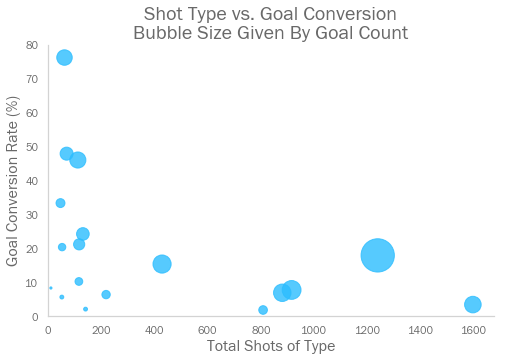

In [13]:
x = df_shots['Total']
y = df_shots['TotalXG'] * 100
s = df_shots['Goals'] * 5

plt.figure(figsize=(8,5))
plt.scatter(x,y,s,alpha=0.8)

plt.xlim(0)
plt.ylim(0)

plt.title('Shot Type vs. Goal Conversion\nBubble Size Given By Goal Count')
plt.xlabel('Total Shots of Type')
plt.ylabel('Goal Conversion Rate (%)');

We can also note the impact of getting a shot on target...

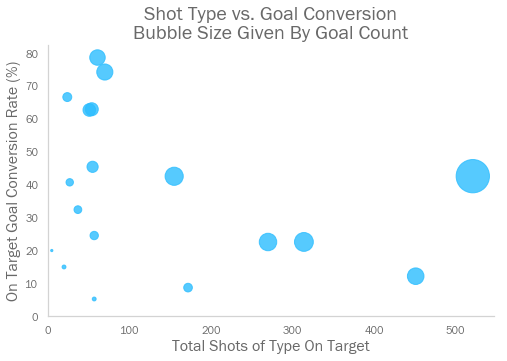

In [14]:
x = df_shots['OnTarget']
y = df_shots['OnTargetXG'] * 100
s = df_shots['Goals'] * 5

plt.figure(figsize=(8,5))
plt.scatter(x,y,s,alpha=0.8)

plt.xlim(0)
plt.ylim(0)

plt.title('Shot Type vs. Goal Conversion\nBubble Size Given By Goal Count')
plt.xlabel('Total Shots of Type On Target')
plt.ylabel('On Target Goal Conversion Rate (%)');

So having calculated the expected success of each shot, we can put this information into our dataframe.

In [15]:
xg_column = []

for row in df.itertuples():
    row_outcome = row.ShotOutcome
    row_class = row.ShotClass
    
    if row_outcome in ['Goal', 'Saved']:
        row_xg = df_shots.loc[row_class, 'OnTargetXG']
    else:
        row_xg = df_shots.loc[row_class, 'TotalXG']
        
    xg_column.append(row_xg)
    
df['XG'] = xg_column

We can then work out the expected goals for each player in each game.

In [16]:
#Let's first bring in the 'player matches' dataframe
df_pm = sql('select * from PlayerMatchesDetail', c).drop('TableIndex', axis=1)
df_pm['GoalInv'] = df_pm['Goals']+df_pm['GoalAssists']
df_pm.head(3)

Player  GameWeek  Minutes    ForTeam  \
PlayerMatchesDetailID                                                  
1                              Alisson         1       90  Liverpool   
2                      Virgil van Dijk         1       90  Liverpool   
3                         Joseph Gomez         1       90  Liverpool   

                        AgainstTeam  RelativeStrength  Goals  ShotsOnTarget  \
PlayerMatchesDetailID                                                         
1                      Norwich City                 3      0              0   
2                      Norwich City                 3      1              1   
3                      Norwich City                 3      0              0   

                       ShotsInBox  CloseShots  ...  GoalAssists  \
PlayerMatchesDetailID                          ...                
1                               0           0  ...            0   
2                               1           1  ...            0   
3                               0           0  ...            0   

                       ShotOnTargetCreated  ShotInBoxCreated  \
PlayerMatchesDetailID                                          
1                                        0                 0   
2                                        0                 0   
3                                        0                 0   

                       CloseShotCreated  TotalShotCreated  HeadersCreated  \
PlayerMatchesDetailID                                                       
1                                     0                 0               0   
2                                     0                 0               0   
3                                     0                 1               0   

                       CreatedCentre  CreatedLeft  CreatedRight  GoalInv  
PlayerMatchesDetailID                                                     
1                                  0            0             0        0  
2                                  0            0             0        1  
3                                  0            0             0        0  

[3 rows x 25 columns]

In [17]:
df_pm.tail(3)

Player  GameWeek  Minutes  \
PlayerMatchesDetailID                                      
16365                      Ryan Giles        29        0   
16366                    Bruno Jordao        29        0   
16367                  Daniel Podence        29       17   

                                       ForTeam               AgainstTeam  \
PlayerMatchesDetailID                                                      
16365                  Wolverhampton Wanderers  Brighton and Hove Albion   
16366                  Wolverhampton Wanderers  Brighton and Hove Albion   
16367                  Wolverhampton Wanderers  Brighton and Hove Albion   

                       RelativeStrength  Goals  ShotsOnTarget  ShotsInBox  \
PlayerMatchesDetailID                                                       
16365                                 2      0              0           0   
16366                                 2      0              0           0   
16367                                 2      0              0           1   

                       CloseShots  ...  GoalAssists  ShotOnTargetCreated  \
PlayerMatchesDetailID              ...                                     
16365                           0  ...            0                    0   
16366                           0  ...            0                    0   
16367                           0  ...            0                    1   

                       ShotInBoxCreated  CloseShotCreated  TotalShotCreated  \
PlayerMatchesDetailID                                                         
16365                                 0                 0                 0   
16366                                 0                 0                 0   
16367                                 1                 1                 1   

                       HeadersCreated  CreatedCentre  CreatedLeft  \
PlayerMatchesDetailID                                               
16365                               0              0            0   
16366                               0              0            0   
16367                               0              1            0   

                       CreatedRight  GoalInv  
PlayerMatchesDetailID                         
16365                             0        0  
16366                             0        0  
16367                             0        0  

[3 rows x 25 columns]

We need to associate a match ID to each row here, so that we can groupby properly.

In [18]:
def MatchIDLookup(gw, ht, at):
    '''
    Takes a gameweek, hometeam, and awayteam,
    and returns the matchID of the game
    '''
    return int(df_fixtures.loc[(df_fixtures['GameWeek']==gw)
                  &(((df_fixtures['HomeTeam']==ht)
                     &(df_fixtures['AwayTeam']==at))
                   |((df_fixtures['HomeTeam']==at)
                     &(df_fixtures['AwayTeam']==ht))),'MatchID'].item())

#Apply the function to insert the matchID
df_pm['MatchID'] = df_pm.apply(lambda x: MatchIDLookup(x['GameWeek'],
                                                       x['ForTeam'],
                                                       x['AgainstTeam']), axis=1)

#Create a multi-index
df_pm.set_index(['MatchID','Player'], inplace=True)
df_pm.head()

GameWeek  Minutes    ForTeam   AgainstTeam  \
MatchID Player                                                               
46605   Alisson                        1       90  Liverpool  Norwich City   
        Virgil van Dijk                1       90  Liverpool  Norwich City   
        Joseph Gomez                   1       90  Liverpool  Norwich City   
        Andrew Robertson               1       90  Liverpool  Norwich City   
        Trent Alexander-Arnold         1       90  Liverpool  Norwich City   

                                RelativeStrength  Goals  ShotsOnTarget  \
MatchID Player                                                           
46605   Alisson                                3      0              0   
        Virgil van Dijk                        3      1              1   
        Joseph Gomez                           3      0              0   
        Andrew Robertson                       3      0              0   
        Trent Alexander-Arnold                 3      0              1   

                                ShotsInBox  CloseShots  TotalShots  ...  \
MatchID Player                                                      ...   
46605   Alisson                          0           0           0  ...   
        Virgil van Dijk                  1           1           1  ...   
        Joseph Gomez                     0           0           0  ...   
        Andrew Robertson                 1           0           2  ...   
        Trent Alexander-Arnold           0           1           2  ...   

                                GoalAssists  ShotOnTargetCreated  \
MatchID Player                                                     
46605   Alisson                           0                    0   
        Virgil van Dijk                   0                    0   
        Joseph Gomez                      0                    0   
        Andrew Robertson                  0                    0   
        Trent Alexander-Arnold            1                    2   

                                ShotInBoxCreated  CloseShotCreated  \
MatchID Player                                                       
46605   Alisson                                0                 0   
        Virgil van Dijk                        0                 0   
        Joseph Gomez                           0                 0   
        Andrew Robertson                       1                 0   
        Trent Alexander-Arnold                 2                 3   

                                TotalShotCreated  HeadersCreated  \
MatchID Player                                                     
46605   Alisson                                0               0   
        Virgil van Dijk                        0               0   
        Joseph Gomez                           1               0   
        Andrew Robertson                       1               0   
        Trent Alexander-Arnold                 3               1   

                                CreatedCentre  CreatedLeft  CreatedRight  \
MatchID Player                                                             
46605   Alisson                             0            0             0   
        Virgil van Dijk                     0            0             0   
        Joseph Gomez                        0            0             0   
        Andrew Robertson                    0            1             0   
        Trent Alexander-Arnold              2            0             0   

                                GoalInv  
MatchID Player                           
46605   Alisson                       0  
        Virgil van Dijk               1  
        Joseph Gomez                  0  
        Andrew Robertson              0  
        Trent Alexander-Arnold        1  

[5 rows x 24 columns]

We now create columns in the player match dataframe, describing their expected goals, assists, and goal involvement.

In [19]:
#Goals
df_pm['XG'] = df.groupby(['MatchID','Player']).sum()[['XG']]
#Assists
df_pm['XA'] = df.groupby(['MatchID','AssistedBy']).sum()[['XG']]

#Fill NAs with 0s
df_pm.fillna(0, inplace=True)

#Calculate goal Involvement
df_pm['XGI'] = df_pm['XG'] + df_pm['XA']

df_pm.head()

GameWeek  Minutes    ForTeam   AgainstTeam  \
MatchID Player                                                               
46605   Alisson                        1       90  Liverpool  Norwich City   
        Virgil van Dijk                1       90  Liverpool  Norwich City   
        Joseph Gomez                   1       90  Liverpool  Norwich City   
        Andrew Robertson               1       90  Liverpool  Norwich City   
        Trent Alexander-Arnold         1       90  Liverpool  Norwich City   

                                RelativeStrength  Goals  ShotsOnTarget  \
MatchID Player                                                           
46605   Alisson                                3      0              0   
        Virgil van Dijk                        3      1              1   
        Joseph Gomez                           3      0              0   
        Andrew Robertson                       3      0              0   
        Trent Alexander-Arnold                 3      0              1   

                                ShotsInBox  CloseShots  TotalShots  ...  \
MatchID Player                                                      ...   
46605   Alisson                          0           0           0  ...   
        Virgil van Dijk                  1           1           1  ...   
        Joseph Gomez                     0           0           0  ...   
        Andrew Robertson                 1           0           2  ...   
        Trent Alexander-Arnold           0           1           2  ...   

                                CloseShotCreated  TotalShotCreated  \
MatchID Player                                                       
46605   Alisson                                0                 0   
        Virgil van Dijk                        0                 0   
        Joseph Gomez                           0                 1   
        Andrew Robertson                       0                 1   
        Trent Alexander-Arnold                 3                 3   

                                HeadersCreated  CreatedCentre  CreatedLeft  \
MatchID Player                                                               
46605   Alisson                              0              0            0   
        Virgil van Dijk                      0              0            0   
        Joseph Gomez                         0              0            0   
        Andrew Robertson                     0              0            1   
        Trent Alexander-Arnold               1              2            0   

                                CreatedRight  GoalInv        XG        XA  \
MatchID Player                                                              
46605   Alisson                            0        0  0.000000  0.000000   
        Virgil van Dijk                    0        1  0.225926  0.000000   
        Joseph Gomez                       0        0  0.000000  0.034483   
        Andrew Robertson                   0        0  0.096160  0.077596   
        Trent Alexander-Arnold             0        1  0.121692  1.112207   

                                     XGI  
MatchID Player                            
46605   Alisson                 0.000000  
        Virgil van Dijk         0.225926  
        Joseph Gomez            0.034483  
        Andrew Robertson        0.173756  
        Trent Alexander-Arnold  1.233899  

[5 rows x 27 columns]

Let's see how player gameweeks are distributed...

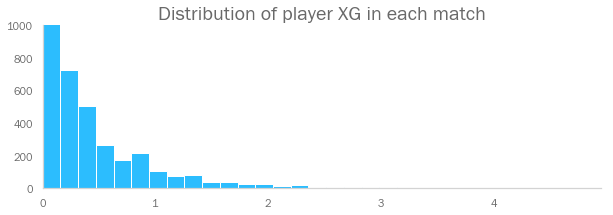

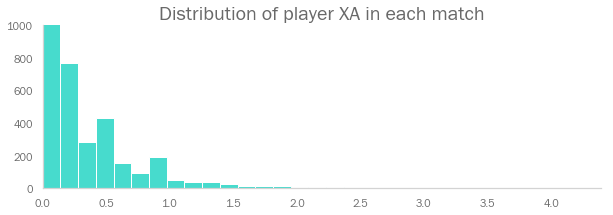

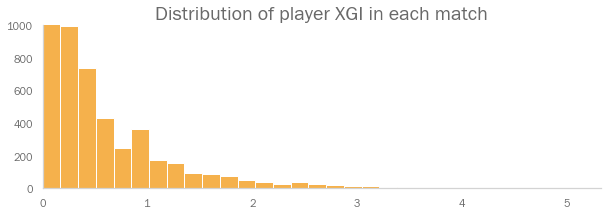

In [20]:
plt.figure(figsize=(10,3))
plt.hist(df_pm['XG'], label='XG', bins=30)

plt.xlim(0)
plt.ylim(0,1000)
plt.title('Distribution of player XG in each match')

plt.figure(figsize=(10,3))
plt.hist(df_pm['XA'], label='XGA', bins=30, color=color_list[1])

plt.xlim(0)
plt.ylim(0,1000)
plt.title('Distribution of player XA in each match')

plt.figure(figsize=(10,3))
plt.hist(df_pm['XGI'], label='XGI', bins=30, color=color_list[2])

plt.xlim(0)
plt.ylim(0,1000)
plt.title('Distribution of player XGI in each match');

Unsurprisingly, the histogram skews heavily left.

We also see that the number of predicted goalscorers is actually well under the real number.

In [21]:
print('Expected Goalscorers:', len(df_pm.loc[df_pm['XG']>=1]))
print('Actual Goalscorers:', (df_pm['Goals']>=1).sum())

Expected Goalscorers: 428
Actual Goalscorers: 692


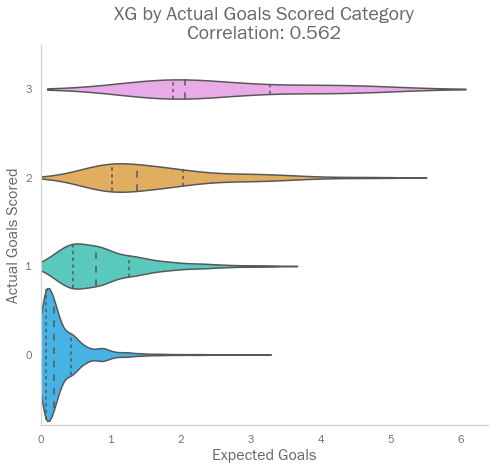

In [22]:
plt.figure(figsize=(8,7))
data = df_pm.loc[df_pm['XG']>0]
sns.violinplot('XG','Goals',data=data,
               width=1.5, inner='quartile', orient='h')

plt.xlim(0)
plt.ylim(-0.8,3.5)

corr = round(np.corrcoef(data['XG'], data['Goals'])[0][1],3)

plt.title(f'XG by Actual Goals Scored Category\nCorrelation: {corr}')
plt.xlabel('Expected Goals')
plt.ylabel('Actual Goals Scored');

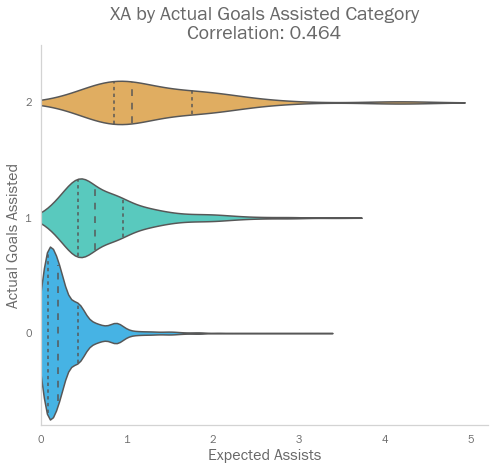

In [23]:
plt.figure(figsize=(8,7))
data = df_pm.loc[(df_pm['XA']>0)&(df_pm['GoalAssists']<3)]


sns.violinplot('XA','GoalAssists',data=data,
               width=1.5, inner='quartile', orient='h')

plt.xlim(0)
plt.ylim(-0.8,2.5)

corr = round(np.corrcoef(data['XA'], data['GoalAssists'])[0][1],3)

plt.title(f'XA by Actual Goals Assisted Category\nCorrelation: {corr}')
plt.xlabel('Expected Assists')
plt.ylabel('Actual Goals Assisted');

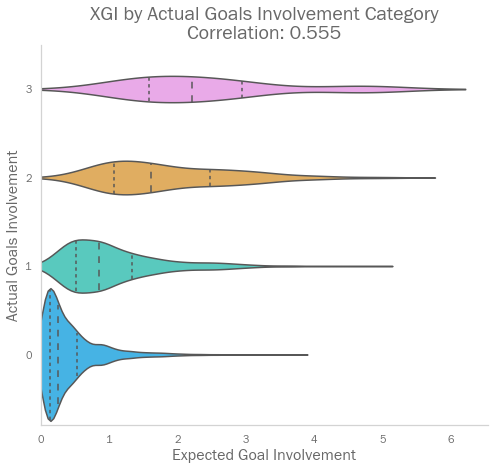

In [24]:
data = df_pm.loc[(df_pm['XGI']>0)&(df_pm['GoalInv']<4)]

plt.figure(figsize=(8,7))
sns.violinplot('XGI','GoalInv',data=data,
               width=1.5, inner='quartile', orient='h')

plt.xlim(0)
plt.ylim(-0.8,3.5)

corr = round(np.corrcoef(data['XGI'], data['GoalInv'])[0][1],3)

plt.title(f'XGI by Actual Goals Involvement Category\nCorrelation: {corr}')
plt.xlabel('Expected Goal Involvement')
plt.ylabel('Actual Goals Involvement');

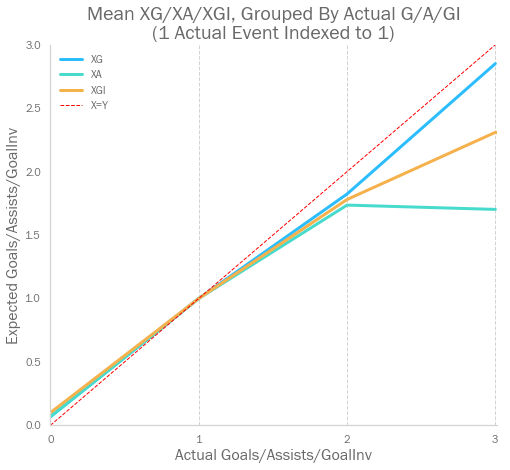

In [25]:
xg_means = [df_pm.loc[(df_pm['Goals']==i)]['XG'].mean()
          for i in [0,1,2,3]]

xa_means = [df_pm.loc[(df_pm['GoalAssists']==i)]['XA'].mean()
          for i in [0,1,2,3]]

xgi_means = [df_pm.loc[(df_pm['GoalInv']==i)]['XGI'].mean()
          for i in [0,1,2,3,4]]


plt.figure(figsize=(8,7))

x1 = np.array(xg_means) / xg_means[1]
x2 = np.array(xa_means) / xa_means[1]
x3 = np.array(xgi_means) / xgi_means[1]

plt.plot(range(4), x1, lw=3, label='XG')
plt.plot(range(4), x2, lw=3, label='XA')
plt.plot(range(5), x3, lw=3, label='XGI')

plt.plot(range(5),range(5), lw=1, color='red',
         ls='--', label='X=Y')
plt.vlines([1,2,3],0,3, color='lightgrey',
           lw=1, linestyles='--')

plt.xticks(range(0,5))

plt.xlim(0,3.01)
plt.ylim(0,3)

plt.legend(frameon=False)

plt.title('Mean XG/XA/XGI, Grouped By Actual G/A/GI\n(1 Actual Event Indexed to 1)')
plt.xlabel('Actual Goals/Assists/GoalInv')
plt.ylabel('Expected Goals/Assists/GoalInv');

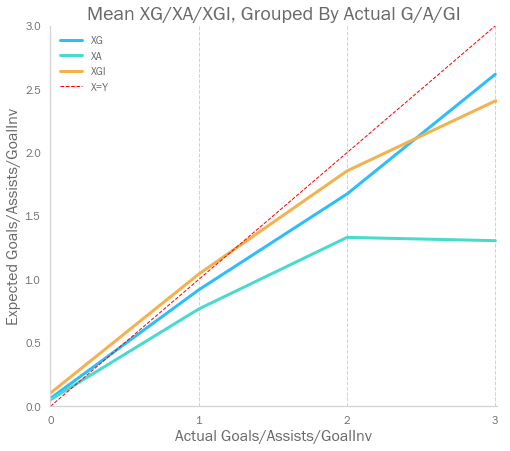

In [26]:
x1 = np.array(xg_means)
x2 = np.array(xa_means)
x3 = np.array(xgi_means)

plt.figure(figsize=(8,7))

plt.plot(range(4), x1, lw=3, label='XG')
plt.plot(range(4), x2, lw=3, label='XA')
plt.plot(range(5), x3, lw=3, label='XGI')

plt.plot(range(5),range(5), lw=1, color='red',
         ls='--', label='X=Y')
plt.vlines([1,2,3],0,3, color='lightgrey',
           lw=1, linestyles='--')

plt.xticks(range(0,5))

plt.xlim(0,3.01)
plt.ylim(0,3)

plt.legend(frameon=False)

plt.title('Mean XG/XA/XGI, Grouped By Actual G/A/GI')
plt.xlabel('Actual Goals/Assists/GoalInv')
plt.ylabel('Expected Goals/Assists/GoalInv');

So we can see that this 'expected' measure is a pretty decent measure of how many goals we would expect a player to score - players scoring two goals had a twice as high XG on average as those that scored one, and those scoring three goals had a mean XG nearly a 3 times higher.

## Modelling XG -> Actual Goals

Out of interest, could we fit a linear model between XG and actual goals?

We can do something a bit quick and dirty to see.

In [27]:
#Create a train test split
X_train, X_test, y_train, y_test = train_test_split(df_pm[['Goals']],
                                                    df_pm['XG'],
                                                    random_state=24)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', round(train_mse,4))
print('Test MSE:', round(test_mse,4))

print('Test r^2:', round(r2_score(y_test, y_hat_test),4))

print('Coef:', round(linreg.coef_[0],4))
print('Intercept:', round(linreg.intercept_,4))

def XG2G(xg):
    return linreg.coef_[0] * xg + linreg.intercept_

Train MSE: 0.0574
Test MSE: 0.0597
Test r^2: 0.4214
Coef: 0.8478
Intercept: 0.0634


What about goal involvement?

In [28]:
#Create a train test split
X_train, X_test, y_train, y_test = train_test_split(df_pm[['XGI']],
                                                    df_pm['GoalInv'],
                                                    random_state=26)

linreg2 = LinearRegression()
linreg2.fit(X_train, y_train)

y_hat_train = linreg2.predict(X_train)
y_hat_test = linreg2.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', round(train_mse,4))
print('Test MSE:', round(test_mse,4))

print('Test r^2:', round(r2_score(y_test, y_hat_test),4))

print('Coef:', round(linreg2.coef_[0],4))
print('Intercept:', round(linreg2.intercept_,4))

def XGI2GI(xgi):
    return linreg2.coef_[0] * xgi + linreg2.intercept_

Train MSE: 0.0591
Test MSE: 0.0604
Test r^2: 0.4137
Coef: 0.4532
Intercept: -0.0011


Our linear models are always going to have a slightly difficult time when the data is technically categorical.

## Getting the data into SQL

Let's get the data into an SQL table for future use.

In [29]:
df_pmsql = df_pm[['GameWeek','ForTeam','AgainstTeam','XG','XA','XGI']]
df_pmsql.reset_index(inplace=True)
# df_pmsql.columns = ['GameWeek','Team','MatchID','GoalsConceded','XGC']
df_pmsql.head()

MatchID                  Player  GameWeek    ForTeam   AgainstTeam  \
0    46605                 Alisson         1  Liverpool  Norwich City   
1    46605         Virgil van Dijk         1  Liverpool  Norwich City   
2    46605            Joseph Gomez         1  Liverpool  Norwich City   
3    46605        Andrew Robertson         1  Liverpool  Norwich City   
4    46605  Trent Alexander-Arnold         1  Liverpool  Norwich City   

         XG        XA       XGI  
0  0.000000  0.000000  0.000000  
1  0.225926  0.000000  0.225926  
2  0.000000  0.034483  0.034483  
3  0.096160  0.077596  0.173756  
4  0.121692  1.112207  1.233899

In [30]:
create_sql_table(df_pmsql, c, table_name = 'PlayersXG', verbose=True)
conn.commit()

populate_sql_from_dataframe(df_pmsql, 'PlayersXG', c, verbose=True)
conn.commit()

CREATE TABLE PlayersXG (PlayersXGID INTEGER PRIMARY KEY, TableIndex TEXT, MatchID INTEGER, Player TEXT, GameWeek INTEGER, ForTeam TEXT, AgainstTeam TEXT, XG REAL, XA REAL, XGI REAL, unique (MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI));

Table not added - possibly already exists
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (0, 46605, "Alisson", 1, "Liverpool", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 0 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1, 46605, "Virgil van Dijk", 1, "Liverpool", "Norwich City", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 1 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
  

                       
Error on row 26 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (27, 46605, "Xherdan Shaqiri", 1, "Liverpool", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 27 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (28, 46605, "Sadio Mane", 1, "Liverpool", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 28 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (29, 46605, "Ralf Fahrmann", 1, "Norwich City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 29 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, P

                       
Error on row 53 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (54, 46606, "John Lundstram", 1, "Sheffield United", "Bournemouth", 0.06896551724137931, 0.3128679562657696, 0.3818334735071489);
                       
Error on row 54 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (55, 46606, "Oliver Norwood", 1, "Sheffield United", "Bournemouth", 0.0, 0.35864297253634897, 0.35864297253634897);
                       
Error on row 55 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (56, 46606, "Callum Robinson", 1, "Sheffield United", "Bournemouth", 0.6025454115607392, 0.0, 0.6025454115607392);


                       
Error on row 89 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (90, 46607, "Yan Valery", 1, "Southampton", "Burnley", 0.0, 0.423728813559322, 0.423728813559322);
                       
Error on row 90 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (91, 46607, "Danny Ings", 1, "Southampton", "Burnley", 0.0, 0.1551912568306011, 0.1551912568306011);
                       
Error on row 91 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (92, 46607, "Che Adams", 1, "Southampton", "Burnley", 0.4608575264306091, 0.0, 0.4608575264306091);
                       
Error on row 92 - you may be trying t

Error on row 147 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (148, 46609, "Ricardo Pereira", 1, "Leicester City", "Wolverhampton Wanderers", 0.03712871287128713, 0.13793103448275862, 0.17505974735404575);
                       
Error on row 148 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (149, 46609, "Youri Tielemans", 1, "Leicester City", "Wolverhampton Wanderers", 0.26128548694326753, 0.3128679562657696, 0.5741534432090372);
                       
Error on row 149 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (150, 46609, "James Maddison", 1, "Leicester City", "Wolverhampton Wanderers", 0.244025264595425

Error on row 177 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (178, 46609, "Patrick Cutrone", 1, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 178 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (179, 46609, "Adama Traore", 1, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 179 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (180, 46610, "Hugo Lloris", 1, "Tottenham Hotspur", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 180 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (

Error on row 211 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (212, 46610, "Douglas Luiz", 1, "Aston Villa", "Tottenham Hotspur", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 212 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (213, 46610, "Henri Lansbury", 1, "Aston Villa", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 213 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (214, 46610, "Jota", 1, "Aston Villa", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 214 - you may be trying to upload a duplicate row
INSERT INTO Pla

                       
Error on row 241 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (242, 46611, "Ken Sema", 1, "Watford", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 242 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (243, 46611, "Roberto Pereyra", 1, "Watford", "Brighton and Hove Albion", 0.11138613861386139, 0.0, 0.11138613861386139);
                       
Error on row 243 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (244, 46611, "Isaac Success", 1, "Watford", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 244 - you may be trying to u

                       
Error on row 278 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (279, 46612, "Pablo Fornals", 1, "West Ham United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 279 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (280, 46612, "Chicharito", 1, "West Ham United", "Manchester City", 0.8887416160970936, 0.0, 0.8887416160970936);
                       
Error on row 280 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (281, 46612, "Claudio Bravo", 1, "Manchester City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 281 - you may be trying to upload

                       
Error on row 323 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (324, 46614, "Martin Dubravka", 1, "Newcastle United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 324 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (325, 46614, "Paul Dummett", 1, "Newcastle United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 325 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (326, 46614, "Fabian Schar", 1, "Newcastle United", "Arsenal", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 326 - you may be trying to upload a duplicate r

                       
Error on row 371 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (372, 46615, "Matthew Lowton", 2, "Burnley", "Arsenal", 0.034482758620689655, 0.06931818181818182, 0.10380094043887148);
                       
Error on row 372 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (373, 46615, "James Tarkowski", 2, "Burnley", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 373 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (374, 46615, "Ben Mee", 2, "Burnley", "Arsenal", 0.22592592592592592, 0.40524741219410043, 0.6311733381200264);
                       
Error on row 374 - you may b

                       
Error on row 421 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (422, 46616, "Conor Hourihane", 2, "Aston Villa", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 422 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (423, 46616, "Jota", 2, "Aston Villa", "Bournemouth", 0.24390243902439024, 0.13863636363636364, 0.3825388026607539);
                       
Error on row 423 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (424, 46616, "Keinan Davis", 2, "Aston Villa", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 424 - you may be trying to upload a duplicate

Error on row 455 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (456, 46617, "Bernardo", 2, "Brighton and Hove Albion", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 456 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (457, 46617, "Aaron Mooy", 2, "Brighton and Hove Albion", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 457 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (458, 46617, "Neal Maupay", 2, "Brighton and Hove Albion", "West Ham United", 0.35864297253634897, 0.0, 0.35864297253634897);
                       
Error on row 458 - you may be trying to upload a

                       
Error on row 490 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (491, 46618, "Marcos Alonso", 2, "Chelsea", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 491 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (492, 46618, "Fikayo Tomori", 2, "Chelsea", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 492 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (493, 46618, "Ross Barkley", 2, "Chelsea", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 493 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Mat

Error on row 541 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (542, 46620, "Oleksandr Zinchenko", 2, "Manchester City", "Tottenham Hotspur", 0.24390243902439024, 0.07759562841530054, 0.3214980674396908);
                       
Error on row 542 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (543, 46620, "Aymeric Laporte", 2, "Manchester City", "Tottenham Hotspur", 0.42610364683301344, 0.0, 0.42610364683301344);
                       
Error on row 543 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (544, 46620, "Nicolas Otamendi", 2, "Manchester City", "Tottenham Hotspur", 0.3936425061425062, 0.034482758620689655,

Error on row 576 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (577, 46621, "Max Aarons", 2, "Norwich City", "Newcastle United", 0.02112676056338028, 0.05263157894736842, 0.0737583395107487);
                       
Error on row 577 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (578, 46621, "Grant Hanley", 2, "Norwich City", "Newcastle United", 0.06931818181818182, 0.0, 0.06931818181818182);
                       
Error on row 578 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (579, 46621, "Jamal Lewis", 2, "Norwich City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 579 - you may be 

Error on row 603 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (604, 46621, "Dennis Srbeny", 2, "Norwich City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 604 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (605, 46621, "Karl Darlow", 2, "Newcastle United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 605 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (606, 46621, "Ciaran Clark", 2, "Newcastle United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 606 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID,

Error on row 641 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (642, 46622, "Gary Cahill", 2, "Crystal Palace", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 642 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (643, 46622, "Jeffrey Schlupp", 2, "Crystal Palace", "Sheffield United", 0.12195121951219512, 0.0, 0.12195121951219512);
                       
Error on row 643 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (644, 46622, "James McCarthy", 2, "Crystal Palace", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 644 - you may be trying to upload a duplicate row
I

Error on row 704 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (705, 46624, "Anthony Martial", 2, "Manchester United", "Wolverhampton Wanderers", 0.8522072936660269, 0.0, 0.8522072936660269);
                       
Error on row 705 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (706, 46624, "John Ruddy", 2, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 706 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (707, 46624, "Ruben Vinagre", 2, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 707 - you may be trying t

Error on row 731 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (732, 46625, "Michael Keane", 3, "Everton", "Aston Villa", 0.0, 0.17932148626817448, 0.17932148626817448);
                       
Error on row 732 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (733, 46625, "Lucas Digne", 3, "Everton", "Aston Villa", 0.18832891246684352, 0.8980733438027104, 1.086402256269554);
                       
Error on row 733 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (734, 46625, "Yerry Mina", 3, "Everton", "Aston Villa", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 734 - you may be

Error on row 769 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (770, 46626, "Aymeric Laporte", 3, "Manchester City", "Bournemouth", 0.0, 0.4276084897777283, 0.4276084897777283);
                       
Error on row 770 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (771, 46626, "Nicolas Otamendi", 3, "Manchester City", "Bournemouth", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 771 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (772, 46626, "Ilkay Gundogan", 3, "Manchester City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 772 - you may be trying to u

                       
Error on row 797 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (798, 46627, "Martin Montoya", 3, "Brighton and Hove Albion", "Southampton", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 798 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (799, 46627, "Davy Propper", 3, "Brighton and Hove Albion", "Southampton", 0.3128679562657696, 0.0, 0.3128679562657696);
                       
Error on row 799 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (800, 46627, "Neal Maupay", 3, "Brighton and Hove Albion", "Southampton", 1.4756921421508755, 0.0689655172413793

Error on row 834 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (835, 46628, "Jordan Henderson", 3, "Liverpool", "Arsenal", 0.07759562841530054, 0.0, 0.07759562841530054);
                       
Error on row 835 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (836, 46628, "Roberto Firmino", 3, "Liverpool", "Arsenal", 0.6627305656579261, 0.0, 0.6627305656579261);
                       
Error on row 836 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (837, 46628, "Sadio Mane", 3, "Liverpool", "Arsenal", 0.5296073920517747, 0.5175145229856933, 1.047121915037468);
                       
Error on row 837 - you may be t

Error on row 863 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (864, 46629, "David de Gea", 3, "Manchester United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 864 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (865, 46629, "Victor Lindelof", 3, "Manchester United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 865 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (866, 46629, "Harry Maguire", 3, "Manchester United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 866 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIn

Error on row 899 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (900, 46630, "Tim Krul", 3, "Norwich City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 900 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (901, 46630, "Max Aarons", 3, "Norwich City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 901 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (902, 46630, "Grant Hanley", 3, "Norwich City", "Chelsea", 0.4258064516129032, 0.0, 0.4258064516129032);
                       
Error on row 902 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Pl

                       
Error on row 927 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (928, 46630, "Dennis Srbeny", 3, "Norwich City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 928 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (929, 46630, "Willy Caballero", 3, "Chelsea", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 929 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (930, 46630, "Marcos Alonso", 3, "Chelsea", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 930 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

Error on row 964 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (965, 46631, "James Justin", 3, "Leicester City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 965 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (966, 46631, "Wes Morgan", 3, "Leicester City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 966 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (967, 46631, "Demarai Gray", 3, "Leicester City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 967 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Matc

Error on row 992 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (993, 46632, "Paulo Gazzaniga", 3, "Tottenham Hotspur", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 993 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (994, 46632, "Jan Vertonghen", 3, "Tottenham Hotspur", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 994 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (995, 46632, "Ben Davies", 3, "Tottenham Hotspur", "Newcastle United", 0.07759562841530054, 0.0, 0.07759562841530054);
                       
Error on row 995 - you may be trying to upload a duplica

Error on row 1029 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1030, 46633, "Daryl Janmaat", 3, "Watford", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 1030 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1031, 46633, "Christian Kabasele", 3, "Watford", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 1031 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1032, 46633, "Nathaniel Chalobah", 3, "Watford", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 1032 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

Error on row 1057 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1058, 46634, "Erik Pieters", 3, "Burnley", "Wolverhampton Wanderers", 0.03712871287128713, 0.1551912568306011, 0.19231996970188822);
                       
Error on row 1058 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1059, 46634, "Jack Cork", 3, "Burnley", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 1059 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1060, 46634, "Johann Gudmundsson", 3, "Burnley", "Wolverhampton Wanderers", 0.35864297253634897, 0.06896551724137931, 0.42760848977772825);
                    

                       
Error on row 1093 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1094, 46635, "Davinson Sanchez", 4, "Tottenham Hotspur", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 1094 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1095, 46635, "Harry Winks", 4, "Tottenham Hotspur", "Arsenal", 0.0, 0.24390243902439024, 0.24390243902439024);
                       
Error on row 1095 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1096, 46635, "Erik Lamela", 4, "Tottenham Hotspur", "Arsenal", 0.12195121951219512, 0.42610364683301344, 0.5480548663452085);
                       
Error o

Error on row 1121 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1122, 46636, "Ashley Westwood", 4, "Burnley", "Liverpool", 0.0, 0.42610364683301344, 0.42610364683301344);
                       
Error on row 1122 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1123, 46636, "Aaron Lennon", 4, "Burnley", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 1123 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1124, 46636, "Chris Wood", 4, "Burnley", "Liverpool", 0.22611464968152867, 0.17932148626817448, 0.4054361359497032);
                       
Error on row 1124 - you may be trying to upload a duplic

Error on row 1156 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1157, 46637, "Ross Barkley", 4, "Chelsea", "Sheffield United", 0.24431651638671015, 0.0, 0.24431651638671015);
                       
Error on row 1157 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1158, 46637, "Mateo Kovacic", 4, "Chelsea", "Sheffield United", 0.07759562841530054, 0.0, 0.07759562841530054);
                       
Error on row 1158 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1159, 46637, "Christian Pulisic", 4, "Chelsea", "Sheffield United", 0.7428571428571429, 0.0, 0.7428571428571429);
                       
Error on row 11

Error on row 1185 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1186, 46637, "Lys Mousset", 4, "Sheffield United", "Chelsea", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 1186 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1187, 46638, "Vicente Guaita", 4, "Crystal Palace", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 1187 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1188, 46638, "Gary Cahill", 4, "Crystal Palace", "Aston Villa", 0.06931818181818182, 0.0, 0.06931818181818182);
                       
Error on row 1188 - you may be trying to uplo

Error on row 1221 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1222, 46638, "Keinan Davis", 4, "Aston Villa", "Crystal Palace", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 1222 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1223, 46639, "Jordan Pickford", 4, "Everton", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 1223 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1224, 46639, "Michael Keane", 4, "Everton", "Wolverhampton Wanderers", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 1224 - you may b

Error on row 1249 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1250, 46638, "Cenk Tosun", 4, "Crystal Palace", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 1250 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1251, 46639, "Bernard", 4, "Everton", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 1251 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1252, 46639, "John Ruddy", 4, "Wolverhampton Wanderers", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 1252 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, 

Error on row 1286 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1287, 46640, "Ayoze Perez", 4, "Leicester City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 1287 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1288, 46640, "Artur Boruc", 4, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 1288 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1289, 46640, "Jack Stacey", 4, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 1289 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Play

Error on row 1313 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1314, 46641, "Neal Maupay", 4, "Brighton and Hove Albion", "Manchester City", 0.20512820512820512, 0.35864297253634897, 0.5637711776645541);
                       
Error on row 1314 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1315, 46641, "Leandro Trossard", 4, "Brighton and Hove Albion", "Manchester City", 0.619097387261687, 0.0, 0.619097387261687);
                       
Error on row 1315 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1316, 46641, "Solly March", 4, "Brighton and Hove Albion", "Manchester City", 0.3076923076923077, 0.15519125

Error on row 1351 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1352, 46642, "Roberto Pereyra", 4, "Watford", "Newcastle United", 0.12195121951219512, 0.2482870035095538, 0.3702382230217489);
                       
Error on row 1352 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1353, 46642, "Karl Darlow", 4, "Newcastle United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 1353 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1354, 46642, "Ciaran Clark", 4, "Newcastle United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 1354 - you may be trying to upload a duplicate row
INS

Error on row 1378 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1379, 46643, "Victor Lindelof", 4, "Manchester United", "Southampton", 0.0, 0.9090909090909091, 0.9090909090909091);
                       
Error on row 1379 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1380, 46643, "Harry Maguire", 4, "Manchester United", "Southampton", 0.0, 0.24390243902439024, 0.24390243902439024);
                       
Error on row 1380 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1381, 46643, "Ashley Young", 4, "Manchester United", "Southampton", 0.03712871287128713, 0.06896551724137931, 0.10609423011266644);
          

Error on row 1415 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1416, 46644, "Christoph Zimmermann", 4, "Norwich City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 1416 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1417, 46644, "Jamal Lewis", 4, "Norwich City", "West Ham United", 0.0, 0.1551912568306011, 0.1551912568306011);
                       
Error on row 1417 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1418, 46644, "Ben Godfrey", 4, "Norwich City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 1418 - you may be trying to upload a duplicate row
INS

Error on row 1442 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1443, 46645, "Tyrone Mings", 5, "Aston Villa", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 1443 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1444, 46645, "John McGinn", 5, "Aston Villa", "West Ham United", 1.1326440551214836, 0.24390243902439024, 1.3765464941458738);
                       
Error on row 1444 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1445, 46645, "Jack Grealish", 5, "Aston Villa", "West Ham United", 0.35864297253634897, 0.9367003367003367, 1.2953433092366857);
                       
Error on row 1

Error on row 1479 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1480, 46646, "Joshua King", 5, "Bournemouth", "Everton", 0.45185185185185184, 1.9264128895864323, 2.3782647414382843);
                       
Error on row 1480 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1481, 46646, "Lewis Cook", 5, "Bournemouth", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 1481 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1482, 46646, "Harry Wilson", 5, "Bournemouth", "Everton", 0.21154731752244993, 0.0, 0.21154731752244993);
                       
Error on row 1482 - you may be trying to upload a dupli

Error on row 1506 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1507, 46646, "Tom Davies", 5, "Everton", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 1507 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1508, 46646, "Theo Walcott", 5, "Everton", "Bournemouth", 0.1744186046511628, 0.0, 0.1744186046511628);
                       
Error on row 1508 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1509, 46646, "Bernard", 5, "Everton", "Bournemouth", 0.1551912568306011, 0.0, 0.1551912568306011);
                       
Error on row 1509 - you may be trying to upload a duplicate row
INSERT INTO P

Error on row 1544 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1545, 46647, "Jay Rodriguez", 5, "Burnley", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 1545 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1546, 46647, "Matej Vydra", 5, "Burnley", "Brighton and Hove Albion", 0.0, 0.24390243902439024, 0.24390243902439024);
                       
Error on row 1546 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1547, 46648, "Adrian", 5, "Liverpool", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 1547 - you may be trying to upload a duplicate row
INSERT 

Error on row 1571 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1572, 46648, "Jordan Henderson", 5, "Liverpool", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 1572 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1573, 46648, "Adam Lallana", 5, "Liverpool", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 1573 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1574, 46648, "Roberto Firmino", 5, "Liverpool", "Newcastle United", 0.29524410774410775, 1.112602166594011, 1.4078462743381186);
                       
Error on row 1574 - you may be trying to upload a duplica

Error on row 1607 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1608, 46649, "Fred", 5, "Manchester United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 1608 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1609, 46649, "Tahith Chong", 5, "Manchester United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 1609 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1610, 46649, "Mason Greenwood", 5, "Manchester United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 1610 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInde

                       
Error on row 1635 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1636, 46650, "Ilkay Gundogan", 5, "Manchester City", "Norwich City", 0.0, 0.06931818181818182, 0.06931818181818182);
                       
Error on row 1636 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1637, 46650, "Rodrigo", 5, "Manchester City", "Norwich City", 0.34787714543812104, 0.4054361359497032, 0.7533132813878243);
                       
Error on row 1637 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1638, 46650, "Bernardo Silva", 5, "Manchester City", "Norwich City", 0.1724105102817974, 0.29524410774410775, 0

Error on row 1671 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1672, 46651, "Oriol Romeu", 5, "Southampton", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 1672 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1673, 46651, "Pierre-Emile Højbjerg", 5, "Southampton", "Sheffield United", 0.0, 0.6760086259238322, 0.6760086259238322);
                       
Error on row 1673 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1674, 46651, "Che Adams", 5, "Southampton", "Sheffield United", 1.0891540210259234, 0.35864297253634897, 1.4477969935622723);
                       
Error on row 1674 - yo

Error on row 1702 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1703, 46652, "Gary Cahill", 5, "Crystal Palace", "Tottenham Hotspur", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 1703 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1704, 46652, "Joel Ward", 5, "Crystal Palace", "Tottenham Hotspur", 0.17932148626817448, 0.06931818181818182, 0.2486396680863563);
                       
Error on row 1704 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1705, 46652, "Patrick van Aanholt", 5, "Crystal Palace", "Tottenham Hotspur", 0.15384615384615385, 0.0, 0.15384615384615385);
 

Error on row 1731 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1732, 46653, "Gerard Deulofeu", 5, "Watford", "Arsenal", 1.049612766061639, 1.1894676010118008, 2.2390803670734396);
                       
Error on row 1732 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1733, 46653, "Tom Cleverley", 5, "Watford", "Arsenal", 0.9663016278211808, 0.6867010551352317, 1.6530026829564126);
                       
Error on row 1733 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1734, 46653, "Abdoulaye Doucoure", 5, "Watford", "Arsenal", 0.5934788633343517, 0.19091673675357446, 0.7843956000879262);
                     

                       
Error on row 1758 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1759, 46653, "Lucas Torreira", 5, "Arsenal", "Watford", 0.24561403508771928, 0.0, 0.24561403508771928);
                       
Error on row 1759 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1760, 46653, "Joe Willock", 5, "Arsenal", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 1760 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1761, 46653, "Gabriel Martinelli", 5, "Arsenal", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 1761 - you may be trying to upload a duplicate row
INSERT INTO Pla

Error on row 1795 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1796, 46654, "Pedro", 5, "Chelsea", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 1796 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1797, 46654, "Olivier Giroud", 5, "Chelsea", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 1797 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1798, 46654, "Michy Batshuayi", 5, "Chelsea", "Wolverhampton Wanderers", 2.290685929579306, 0.45222929936305734, 2.7429152289423633);
                       
Error on row 1798 - you may be trying to upload a d

Error on row 1829 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1830, 46655, "Ahmed El Mohamady", 6, "Aston Villa", "Arsenal", 0.0, 0.3012727057803696, 0.3012727057803696);
                       
Error on row 1830 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1831, 46655, "Henri Lansbury", 6, "Aston Villa", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 1831 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1832, 46655, "Conor Hourihane", 6, "Aston Villa", "Arsenal", 0.17932148626817448, 0.0, 0.17932148626817448);
                       
Error on row 1832 - you may be trying to upload a duplicat

Error on row 1859 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1860, 46656, "Robbie Brady", 6, "Burnley", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 1860 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1861, 46656, "Aaron Lennon", 6, "Burnley", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 1861 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1862, 46656, "Jay Rodriguez", 6, "Burnley", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 1862 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, 

Error on row 1913 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1914, 46658, "Wilfried Zaha", 6, "Crystal Palace", "Wolverhampton Wanderers", 0.5601935874168179, 0.0, 0.5601935874168179);
                       
Error on row 1914 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1915, 46658, "Jeffrey Schlupp", 6, "Crystal Palace", "Wolverhampton Wanderers", 1.007398550496628, 0.8522072936660269, 1.859605844162655);
                       
Error on row 1915 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1916, 46658, "James McArthur", 6, "Crystal Palace", "Wolverhampton Wanderers", 0.0, 0.22415677407198042, 0.224156

Error on row 1939 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1940, 46658, "Morgan Gibbs-White", 6, "Wolverhampton Wanderers", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 1940 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1941, 46658, "Pedro Neto", 6, "Wolverhampton Wanderers", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 1941 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1942, 46658, "Patrick Cutrone", 6, "Wolverhampton Wanderers", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 1942 - you may be trying to upload a duplicate row
IN

Error on row 1977 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1978, 46659, "Lys Mousset", 6, "Sheffield United", "Everton", 0.22611464968152867, 0.0, 0.22611464968152867);
                       
Error on row 1978 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1979, 46660, "Kasper Schmeichel", 6, "Leicester City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 1979 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1980, 46660, "Ben Chilwell", 6, "Leicester City", "Tottenham Hotspur", 0.0, 0.1551912568306011, 0.1551912568306011);
                       
Error on row 1980 - you may be tr

Error on row 2003 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2004, 46660, "Demarai Gray", 6, "Leicester City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 2004 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2005, 46660, "Marc Albrighton", 6, "Leicester City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 2005 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2006, 46660, "Hamza Choudhury", 6, "Leicester City", "Tottenham Hotspur", 0.0, 0.24390243902439024, 0.24390243902439024);
                       
Error on row 2006 - you may be trying to upload a dup

Error on row 2042 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2043, 46661, "Gabriel Jesus", 6, "Manchester City", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 2043 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2044, 46661, "Heurelho Gomes", 6, "Watford", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 2044 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2045, 46661, "Daryl Janmaat", 6, "Watford", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 2045 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player

Error on row 2068 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2069, 46662, "Steven Alzate", 6, "Brighton and Hove Albion", "Newcastle United", 0.0, 0.42760848977772825, 0.42760848977772825);
                       
Error on row 2069 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2070, 46662, "Neal Maupay", 6, "Brighton and Hove Albion", "Newcastle United", 1.7130411572680717, 0.0, 1.7130411572680717);
                       
Error on row 2070 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2071, 46662, "Pascal Groß", 6, "Brighton and Hove Albion", "Newcastle United", 0.13793103448275862, 0.42928497920018555, 0

Error on row 2105 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2106, 46663, "Philip Billing", 6, "Bournemouth", "Southampton", 0.03712871287128713, 0.8522072936660269, 0.889336006537314);
                       
Error on row 2106 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2107, 46663, "Dominic Solanke", 6, "Bournemouth", "Southampton", 0.0, 0.06896551724137931, 0.06896551724137931);
                       
Error on row 2107 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2108, 46663, "Callum Wilson", 6, "Bournemouth", "Southampton", 0.8522072936660269, 0.0, 0.8522072936660269);
                       
Error

Error on row 2136 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2137, 46664, "Ashley Young", 6, "Manchester United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 2137 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2138, 46664, "Aaron Wan-Bissaka", 6, "Manchester United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 2138 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2139, 46664, "Juan Mata", 6, "Manchester United", "West Ham United", 0.9893194995422643, 0.10526315789473684, 1.0945826574370012);
                       
Error on row 2139 - you may be trying to

Error on row 2169 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2170, 46665, "Nick Pope", 7, "Burnley", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 2170 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2171, 46665, "Matthew Lowton", 7, "Burnley", "Aston Villa", 0.0, 0.6274509803921569, 0.6274509803921569);
                       
Error on row 2171 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2172, 46665, "James Tarkowski", 7, "Burnley", "Aston Villa", 0.24242424242424243, 0.0, 0.24242424242424243);
                       
Error on row 2172 - you may be trying to upload a duplicate row
IN

                       
Error on row 2196 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2197, 46666, "Nathan Ake", 7, "Bournemouth", "West Ham United", 0.2231643356643357, 0.7428571428571429, 0.9660214785214786);
                       
Error on row 2197 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2198, 46666, "Jack Stacey", 7, "Bournemouth", "West Ham United", 0.0, 0.12195121951219512, 0.12195121951219512);
                       
Error on row 2198 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2199, 46666, "Diego Rico", 7, "Bournemouth", "West Ham United", 0.0, 0.979046537275904, 0.979046537275904);
      

Error on row 2233 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2234, 46667, "Cesar Azpilicueta", 7, "Chelsea", "Brighton and Hove Albion", 0.0, 0.9203539823008849, 0.9203539823008849);
                       
Error on row 2234 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2235, 46667, "Fikayo Tomori", 7, "Chelsea", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 2235 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2236, 46667, "Jorginho", 7, "Chelsea", "Brighton and Hove Albion", 1.6427360090446579, 1.6630795655654333, 3.305815574610091);
                       
Error on row 22

Error on row 2260 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2261, 46667, "Gaetan Bong", 7, "Brighton and Hove Albion", "Chelsea", 0.0, 1.0755452391314861, 1.0755452391314861);
                       
Error on row 2261 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2262, 46667, "Ezequiel Schelotto", 7, "Brighton and Hove Albion", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 2262 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2263, 46667, "Tudor Baluta", 7, "Brighton and Hove Albion", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 2263 - you may be trying to upload a duplic

Error on row 2298 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2299, 46668, "Patrick Roberts", 7, "Norwich City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 2299 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2300, 46668, "Josip Drmic", 7, "Norwich City", "Crystal Palace", 0.06931818181818182, 0.0, 0.06931818181818182);
                       
Error on row 2300 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2301, 46668, "Dennis Srbeny", 7, "Norwich City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 2301 - you may be trying to upload a duplicate row
INSERT 

Error on row 2325 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2326, 46669, "Mason Holgate", 7, "Everton", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 2326 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2327, 46669, "Djibril Sidibe", 7, "Everton", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 2327 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2328, 46669, "Tom Davies", 7, "Everton", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 2328 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, G

Error on row 2363 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2364, 46670, "Demarai Gray", 7, "Leicester City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 2364 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2365, 46670, "Marc Albrighton", 7, "Leicester City", "Newcastle United", 0.0, 1.323867478025693, 1.323867478025693);
                       
Error on row 2365 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2366, 46670, "Hamza Choudhury", 7, "Leicester City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 2366 - you may be trying to upload a duplicate 

Error on row 2390 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2391, 46671, "Lucas Torreira", 7, "Arsenal", "Manchester United", 0.17932148626817448, 0.0, 0.17932148626817448);
                       
Error on row 2391 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2392, 46671, "Matteo Guendouzi", 7, "Arsenal", "Manchester United", 0.15, 0.0, 0.15);
                       
Error on row 2392 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2393, 46671, "Granit Xhaka", 7, "Arsenal", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 2393 - you may be trying to upload a duplicate row
INSERT I

Error on row 2426 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2427, 46672, "Fabinho", 7, "Liverpool", "Sheffield United", 0.018564356435643563, 0.17932148626817448, 0.19788584270381804);
                       
Error on row 2427 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2428, 46672, "Georginio Wijnaldum", 7, "Liverpool", "Sheffield United", 0.1429023716325121, 0.0, 0.1429023716325121);
                       
Error on row 2428 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2429, 46672, "Jordan Henderson", 7, "Liverpool", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 2429 - you 

Error on row 2454 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2455, 46673, "Christian Eriksen", 7, "Tottenham Hotspur", "Southampton", 0.06896551724137931, 1.7044145873320538, 1.773380104573433);
                       
Error on row 2455 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2456, 46673, "Tanguy Ndombele", 7, "Tottenham Hotspur", "Southampton", 1.210850266202376, 0.6666666666666666, 1.8775169328690424);
                       
Error on row 2456 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2457, 46673, "Harry Kane", 7, "Tottenham Hotspur", "Southampton", 1.6740652171632946, 0.0, 1.6740652171632946);

Error on row 2491 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2492, 46674, "Adama Traore", 7, "Wolverhampton Wanderers", "Watford", 0.0, 0.423728813559322, 0.423728813559322);
                       
Error on row 2492 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2493, 46674, "Ben Foster", 7, "Watford", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 2493 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2494, 46674, "Daryl Janmaat", 7, "Watford", "Wolverhampton Wanderers", 0.0, 0.35864297253634897, 0.35864297253634897);
                       
Error on row 2494 - you may be tryi

Error on row 2518 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2519, 46675, "Sokratis", 8, "Arsenal", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 2519 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2520, 46675, "Calum Chambers", 8, "Arsenal", "Bournemouth", 0.6160487832612103, 0.9203539823008849, 1.5364027655620953);
                       
Error on row 2520 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2521, 46675, "David Luiz", 8, "Arsenal", "Bournemouth", 0.45185185185185184, 0.0, 0.45185185185185184);
                       
Error on row 2521 - you may be trying to upload a duplica

                       
Error on row 2567 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2568, 46676, "Moussa Sissoko", 8, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 2568 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2569, 46676, "Ben Davies", 8, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 2569 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2570, 46676, "Son Heung-Min", 8, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 2570 - you may be tryin

Error on row 2625 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2626, 46678, "Adrian", 8, "Liverpool", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 2626 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2627, 46678, "Virgil van Dijk", 8, "Liverpool", "Leicester City", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 2627 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2628, 46678, "Dejan Lovren", 8, "Liverpool", "Leicester City", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 2628 - you may be trying to upload a dupl

Error on row 2656 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2657, 46678, "Wes Morgan", 8, "Leicester City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 2657 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2658, 46678, "Demarai Gray", 8, "Leicester City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 2658 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2659, 46678, "Marc Albrighton", 8, "Leicester City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 2659 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player

                       
Error on row 2684 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2685, 46679, "Oleksandr Zinchenko", 8, "Manchester City", "Wolverhampton Wanderers", 0.13793103448275862, 0.6524705930033137, 0.7904016274860723);
                       
Error on row 2685 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2686, 46679, "Angelino", 8, "Manchester City", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 2686 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2687, 46679, "Eric Garcia", 8, "Manchester City", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                      

                       
Error on row 2760 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2761, 46681, "Dennis Srbeny", 8, "Norwich City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 2761 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2762, 46681, "Adam Idah", 8, "Norwich City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 2762 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2763, 46681, "Jed Steer", 8, "Aston Villa", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 2763 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInde

Error on row 2806 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2807, 46683, "Daryl Janmaat", 8, "Watford", "Sheffield United", 0.0, 0.10380094043887148, 0.10380094043887148);
                       
Error on row 2807 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2808, 46683, "Sebastian Prodl", 8, "Watford", "Sheffield United", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 2808 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2809, 46683, "Craig Cathcart", 8, "Watford", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 2809 - you may be trying to uplo

Error on row 2863 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2864, 46684, "David Martin", 8, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 2864 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2865, 46684, "Fabian Balbuena", 8, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 2865 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2866, 46684, "Pablo Zabaleta", 8, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 2866 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Table

Error on row 2923 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2924, 46686, "Callum Wilson", 9, "Bournemouth", "Norwich City", 0.4276084897777283, 0.9090909090909091, 1.3366993988686373);
                       
Error on row 2924 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2925, 46686, "Tim Krul", 9, "Norwich City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 2925 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2926, 46686, "Max Aarons", 9, "Norwich City", "Bournemouth", 0.0, 0.06896551724137931, 0.06896551724137931);
                       
Error on row 2926 - you may be trying to up

Error on row 2991 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2992, 46688, "Cheikhou Kouyate", 9, "Crystal Palace", "Manchester City", 0.034482758620689655, 0.42610364683301344, 0.4605864054537031);
                       
Error on row 2992 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2993, 46688, "Wilfried Zaha", 9, "Crystal Palace", "Manchester City", 0.42610364683301344, 0.07759562841530054, 0.503699275248314);
                       
Error on row 2993 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2994, 46688, "Jeffrey Schlupp", 9, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                   

Error on row 3058 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3059, 46690, "Ben Chilwell", 9, "Leicester City", "Burnley", 0.03712871287128713, 0.0, 0.03712871287128713);
                       
Error on row 3059 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3060, 46690, "Caglar Soyuncu", 9, "Leicester City", "Burnley", 0.3053030303030303, 0.0, 0.3053030303030303);
                       
Error on row 3060 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3061, 46690, "Jonny Evans", 9, "Leicester City", "Burnley", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 3061 - you ma

Error on row 3125 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3126, 46691, "James Milner", 9, "Liverpool", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 3126 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3127, 46691, "Naby Keita", 9, "Liverpool", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 3127 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3128, 46691, "Alex Oxlade-Chamberlain", 9, "Liverpool", "Manchester United", 0.06896551724137931, 0.0, 0.06896551724137931);
                       
Error on row 3128 - you may be trying to upload a duplicate row
I

Error on row 3192 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3193, 46693, "Tanguy Ndombele", 9, "Tottenham Hotspur", "Watford", 0.17932148626817448, 0.0, 0.17932148626817448);
                       
Error on row 3193 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3194, 46693, "Son Heung-Min", 9, "Tottenham Hotspur", "Watford", 0.07759562841530054, 0.0, 0.07759562841530054);
                       
Error on row 3194 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3195, 46693, "Heurelho Gomes", 9, "Watford", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 3195 - you may be trying to u

Error on row 3257 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3258, 46695, "James McArthur", 10, "Crystal Palace", "Arsenal", 0.22592592592592592, 0.6576576576576576, 0.8835835835835835);
                       
Error on row 3258 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3259, 46695, "Jordan Ayew", 10, "Crystal Palace", "Arsenal", 0.8115038115038116, 0.07759562841530054, 0.8890994399191121);
                       
Error on row 3259 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3260, 46695, "Emiliano Martinez", 10, "Arsenal", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 3260 - 

Error on row 3323 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3324, 46697, "Cesar Azpilicueta", 10, "Chelsea", "Burnley", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 3324 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3325, 46697, "Fikayo Tomori", 10, "Chelsea", "Burnley", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 3325 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3326, 46697, "Christian Pulisic", 10, "Chelsea", "Burnley", 1.589210252633688, 0.3381930367175189, 1.927403289351207);
                       
Error on row 3326

Error on row 3391 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3392, 46699, "Bernardo Silva", 10, "Manchester City", "Aston Villa", 0.3830251899718782, 0.6049829838771987, 0.9880081738490769);
                       
Error on row 3392 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3393, 46699, "Tom Heaton", 10, "Aston Villa", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 3393 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3394, 46699, "Matt Targett", 10, "Aston Villa", "Manchester City", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 3394 - you ma

Error on row 3458 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3459, 46701, "Moritz Leitner", 10, "Norwich City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 3459 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3460, 46701, "Todd Cantwell", 10, "Norwich City", "Manchester United", 0.3012727057803696, 0.034482758620689655, 0.33575546440105924);
                       
Error on row 3460 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3461, 46701, "Emiliano Buendia", 10, "Norwich City", "Manchester United", 0.0, 0.3338156262918561, 0.3338156262918561);
                       
Error on 

Error on row 3518 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3519, 46702, "Danny Ward", 10, "Leicester City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 3519 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3520, 46702, "James Justin", 10, "Leicester City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 3520 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3521, 46702, "Wes Morgan", 10, "Leicester City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 3521 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Pl

Error on row 3586 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3587, 46704, "Manuel Lanzini", 10, "West Ham United", "Sheffield United", 0.0, 0.13863636363636364, 0.13863636363636364);
                       
Error on row 3587 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3588, 46704, "Carlos Sanchez", 10, "West Ham United", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 3588 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3589, 46704, "Pablo Fornals", 10, "West Ham United", "Sheffield United", 0.0, 0.423728813559322, 0.423728813559322);
                       
Error on row 3589 - you

Error on row 3653 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3654, 46706, "Sadio Mane", 11, "Liverpool", "Aston Villa", 0.8453205920194986, 0.6829672968606733, 1.5282878888801719);
                       
Error on row 3654 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3655, 46706, "Mohamed Salah", 11, "Liverpool", "Aston Villa", 0.3689999264003351, 0.0, 0.3689999264003351);
                       
Error on row 3655 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3656, 46706, "Jed Steer", 11, "Aston Villa", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 3656 - you may be trying to upload a 

Error on row 3720 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3721, 46708, "Ben Godfrey", 11, "Norwich City", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 3721 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3722, 46708, "Tom Trybull", 11, "Norwich City", "Brighton and Hove Albion", 0.4972793361727126, 0.0, 0.4972793361727126);
                       
Error on row 3722 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3723, 46708, "Onel Hernandez", 11, "Norwich City", "Brighton and Hove Albion", 0.0, 0.04225352112676056, 0.04225352112676056);
                       
Error on ro

Error on row 3786 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3787, 46710, "Tom Davies", 11, "Everton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 3787 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3788, 46710, "Richarlison", 11, "Everton", "Tottenham Hotspur", 0.964285680702017, 0.0, 0.964285680702017);
                       
Error on row 3788 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3789, 46710, "Paulo Gazzaniga", 11, "Tottenham Hotspur", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 3789 - you may be trying to upload a duplicate row
INSERT INTO Playe

Error on row 3853 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3854, 46712, "George Baldock", 11, "Sheffield United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 3854 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3855, 46712, "Enda Stevens", 11, "Sheffield United", "Burnley", 0.15384615384615385, 0.21380424488886413, 0.367650398735018);
                       
Error on row 3855 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3856, 46712, "John Fleck", 11, "Sheffield United", "Burnley", 0.22611464968152867, 0.07759562841530054, 0.3037102780968292);
                       
Error on row 3856 -

Error on row 3921 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3922, 46714, "Roberto Jimenez", 11, "West Ham United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 3922 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3923, 46714, "Aaron Cresswell", 11, "West Ham United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 3923 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3924, 46714, "Fabian Balbuena", 11, "West Ham United", "Newcastle United", 2.6932389321323082, 0.0, 2.6932389321323082);
                       
Error on row 3924 - you may be trying to upload a

Error on row 3988 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3989, 46715, "Angelo Ogbonna", 12, "West Ham United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 3989 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3990, 46715, "Manuel Lanzini", 12, "West Ham United", "Burnley", 0.06896551724137931, 0.1551912568306011, 0.2241567740719804);
                       
Error on row 3990 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3991, 46715, "Carlos Sanchez", 12, "West Ham United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 3991 - you may be trying to upload a duplicate row

Error on row 4055 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4056, 46717, "Marc Albrighton", 12, "Leicester City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 4056 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4057, 46717, "Hamza Choudhury", 12, "Leicester City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 4057 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4058, 46717, "Dennis Praet", 12, "Leicester City", "Arsenal", 0.1551912568306011, 0.0, 0.1551912568306011);
                       
Error on row 4058 - you may be trying to upload a duplicate row
INSERT INTO Player

Error on row 4123 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4124, 46719, "Sergio Romero", 12, "Manchester United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 4124 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4125, 46719, "Phil Jones", 12, "Manchester United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 4125 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4126, 46719, "Marcos Rojo", 12, "Manchester United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 4126 - you may be trying to upload a duplicate 

Error on row 4190 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4191, 46721, "Abdoulaye Doucoure", 12, "Watford", "Norwich City", 0.08249129707491297, 0.0, 0.08249129707491297);
                       
Error on row 4191 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4192, 46721, "Will Hughes", 12, "Watford", "Norwich City", 0.15384615384615385, 0.29139987330416467, 0.4452460271503185);
                       
Error on row 4192 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4193, 46721, "Etienne Capoue", 12, "Watford", "Norwich City", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Erro

                       
Error on row 4257 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4258, 46723, "Jack O'Connell", 12, "Sheffield United", "Tottenham Hotspur", 0.0, 0.17932148626817448, 0.17932148626817448);
                       
Error on row 4258 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4259, 46723, "Chris Basham", 12, "Sheffield United", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 4259 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4260, 46723, "John Egan", 12, "Sheffield United", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 4260 - you may

Error on row 4324 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4325, 46725, "Matteo Guendouzi", 13, "Arsenal", "Southampton", 0.0, 0.1551912568306011, 0.1551912568306011);
                       
Error on row 4325 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4326, 46725, "Alexandre Lacazette", 13, "Arsenal", "Southampton", 2.110872162485066, 0.8522072936660269, 2.963079456151093);
                       
Error on row 4326 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4327, 46725, "Mesut Ozil", 13, "Arsenal", "Southampton", 0.8522072936660269, 1.4464105241972771, 2.298617817863304);
                       
E

Error on row 4391 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4392, 46727, "Steve Cook", 13, "Bournemouth", "Wolverhampton Wanderers", 0.76185619581846, 0.8522072936660269, 1.614063489484487);
                       
Error on row 4392 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4393, 46727, "Nathan Ake", 13, "Bournemouth", "Wolverhampton Wanderers", 0.9908436573023905, 0.0, 0.9908436573023905);
                       
Error on row 4393 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4394, 46727, "Adam Smith", 13, "Bournemouth", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 

Error on row 4458 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4459, 46728, "Marc Albrighton", 13, "Leicester City", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 4459 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4460, 46728, "Dennis Praet", 13, "Leicester City", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 4460 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4461, 46728, "Kelechi Iheanacho", 13, "Leicester City", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 4461 - you may be trying to upload a duplicate

                       
Error on row 4525 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4526, 46730, "Moise Kean", 13, "Everton", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 4526 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4527, 46730, "Ralf Fahrmann", 13, "Norwich City", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 4527 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4528, 46730, "Patrick Roberts", 13, "Norwich City", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 4528 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex,

Error on row 4591 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4592, 46732, "Michael Verrips", 13, "Sheffield United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 4592 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4593, 46732, "Luke Freeman", 13, "Sheffield United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 4593 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4594, 46732, "Ben Osborn", 13, "Sheffield United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 4594 - you may be trying to upload a duplicate row
INSERT INTO Playe

Error on row 4652 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4653, 46734, "Paulo Gazzaniga", 13, "Tottenham Hotspur", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 4653 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4654, 46734, "Toby Alderweireld", 13, "Tottenham Hotspur", "West Ham United", 0.5637711776645541, 0.0, 0.5637711776645541);
                       
Error on row 4654 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4655, 46734, "Davinson Sanchez", 13, "Tottenham Hotspur", "West Ham United", 0.45185185185185184, 0.0, 0.45185185185185184);
                       
Error on ro

                       
Error on row 4718 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4719, 46736, "Christian Pulisic", 14, "Chelsea", "West Ham United", 1.156530654386295, 0.4878048780487805, 1.6443355324350755);
                       
Error on row 4719 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4720, 46736, "Jorginho", 14, "Chelsea", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 4720 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4721, 46736, "Pedro", 14, "Chelsea", "West Ham United", 1.1593052109181141, 0.13863636363636364, 1.2979415745544778);
                       
Error o

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4783, 46737, "Bernard", 14, "Everton", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 4783 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4784, 46737, "Moise Kean", 14, "Everton", "Leicester City", 0.5211948166044367, 0.0, 0.5211948166044367);
                       
Error on row 4784 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4785, 46737, "Anthony Gordon", 14, "Everton", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 4785 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, X

Error on row 4848 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4849, 46739, "James Garner", 14, "Manchester United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 4849 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4850, 46739, "Mason Greenwood", 14, "Manchester United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 4850 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4851, 46739, "Ørjan Nyland", 14, "Aston Villa", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 4851 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIn

Error on row 4916 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4917, 46741, "Jamal Lewis", 14, "Norwich City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 4917 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4918, 46741, "Patrick Roberts", 14, "Norwich City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 4918 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4919, 46741, "Mario Vrancic", 14, "Norwich City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 4919 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameW

Error on row 4982 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4983, 46743, "Arnaut Danjuma Groeneveld", 14, "Bournemouth", "Tottenham Hotspur", 0.418321043675553, 0.0, 0.418321043675553);
                       
Error on row 4983 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4984, 46743, "Lewis Cook", 14, "Bournemouth", "Tottenham Hotspur", 0.24390243902439024, 1.2209516193522592, 1.4648540583766494);
                       
Error on row 4984 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4985, 46743, "Ryan Fraser", 14, "Bournemouth", "Tottenham Hotspur", 0.0, 0.13863636363636364, 0.13863636363636364);
     

                       
Error on row 5048 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5049, 46745, "Mat Ryan", 15, "Brighton and Hove Albion", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 5049 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5050, 46745, "Lewis Dunk", 15, "Brighton and Hove Albion", "Arsenal", 0.48484848484848486, 0.35864297253634897, 0.8434914573848338);
                       
Error on row 5050 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5051, 46745, "Adam Webster", 15, "Brighton and Hove Albion", "Arsenal", 1.3034647550776581, 0.24390243902439024, 1.5473671941020484);
 

                       
Error on row 5114 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5115, 46747, "Youri Tielemans", 15, "Leicester City", "Watford", 0.0, 0.1551912568306011, 0.1551912568306011);
                       
Error on row 5115 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5116, 46747, "James Maddison", 15, "Leicester City", "Watford", 0.8522072936660269, 0.6992335781068174, 1.5514408717728443);
                       
Error on row 5116 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5117, 46747, "Harvey Barnes", 15, "Leicester City", "Watford", 1.8035517238836964, 0.0, 1.8035517238836964);
       

                       
Error on row 5181 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5182, 46749, "Dean Henderson", 15, "Sheffield United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 5182 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5183, 46749, "Jack O'Connell", 15, "Sheffield United", "Newcastle United", 0.4074074074074074, 0.0, 0.4074074074074074);
                       
Error on row 5183 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5184, 46749, "Chris Basham", 15, "Sheffield United", "Newcastle United", 0.0, 0.22592592592592592, 0.22592592592592592);
                   

                       
Error on row 5248 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5249, 46750, "Arthur Masuaku", 15, "West Ham United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 5249 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5250, 46750, "Carlos Sanchez", 15, "West Ham United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 5250 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5251, 46750, "Nathan Holland", 15, "West Ham United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 5251 - you may be trying

                       
Error on row 5314 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5315, 46752, "Victor Camarasa", 15, "Crystal Palace", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 5315 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5316, 46752, "Jairo Riedewald", 15, "Crystal Palace", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 5316 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5317, 46752, "Christian Benteke", 15, "Crystal Palace", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 5317 - you may be trying to upload a duplicate row
INSERT 

                       
Error on row 5380 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5381, 46754, "Kenny McLean", 15, "Norwich City", "Southampton", 0.06896551724137931, 0.0, 0.06896551724137931);
                       
Error on row 5381 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5382, 46754, "Ibrahim Amadou", 15, "Norwich City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 5382 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5383, 46754, "Teemu Pukki", 15, "Norwich City", "Southampton", 0.7650972556288269, 0.06896551724137931, 0.8340627728702062);
                       
Error on 

Error on row 5446 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5447, 46756, "Dejan Lovren", 16, "Liverpool", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 5447 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5448, 46756, "Joseph Gomez", 16, "Liverpool", "Bournemouth", 0.0, 0.8522292993630574, 0.8522292993630574);
                       
Error on row 5448 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5449, 46756, "Andrew Robertson", 16, "Liverpool", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 5449 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (

Error on row 5512 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5513, 46758, "Alex Iwobi", 16, "Everton", "Chelsea", 0.0, 0.22611464968152867, 0.22611464968152867);
                       
Error on row 5513 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5514, 46758, "Morgan Schneiderlin", 16, "Everton", "Chelsea", 0.018564356435643563, 0.0, 0.018564356435643563);
                       
Error on row 5514 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5515, 46758, "Richarlison", 16, "Everton", "Chelsea", 0.8535656300736856, 0.0, 0.8535656300736856);
                       
Error on row 5515 - you may be trying t

Error on row 5578 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5579, 46760, "Ciaran Clark", 16, "Newcastle United", "Southampton", 0.45185185185185184, 0.0, 0.45185185185185184);
                       
Error on row 5579 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5580, 46760, "Paul Dummett", 16, "Newcastle United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 5580 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5581, 46760, "Jetro Willems", 16, "Newcastle United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 5581 - you may be trying to upload a duplicate row
INS

Error on row 5644 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5645, 46761, "Luke Freeman", 16, "Sheffield United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 5645 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5646, 46761, "Muhamed Besic", 16, "Sheffield United", "Norwich City", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 5646 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5647, 46761, "Oliver McBurnie", 16, "Sheffield United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 5647 - you may be trying to upload a duplicate r

Error on row 5709 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5710, 46763, "Adrian Mariappa", 16, "Watford", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 5710 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5711, 46763, "Nathaniel Chalobah", 16, "Watford", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 5711 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5712, 46763, "Will Hughes", 16, "Watford", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 5712 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Pl

                       
Error on row 5775 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5776, 46765, "Rodrigo", 17, "Manchester City", "Arsenal", 0.0, 0.12195121951219512, 0.12195121951219512);
                       
Error on row 5776 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5777, 46765, "Kevin De Bruyne", 17, "Manchester City", "Arsenal", 0.8264400639902884, 0.35864297253634897, 1.1850830365266374);
                       
Error on row 5777 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5778, 46765, "Phil Foden", 17, "Manchester City", "Arsenal", 0.06931818181818182, 0.24390243902439024, 0.3132206208425

                       
Error on row 5839 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5840, 46767, "Tammy Abraham", 17, "Chelsea", "Bournemouth", 1.89081766059339, 0.1551912568306011, 2.046008917423991);
                       
Error on row 5840 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5841, 46767, "Aaron Ramsdale", 17, "Bournemouth", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 5841 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5842, 46767, "Simon Francis", 17, "Bournemouth", "Chelsea", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 5842 - you m

Error on row 5901 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5902, 46769, "Kasper Schmeichel", 17, "Leicester City", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 5902 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5903, 46769, "Ben Chilwell", 17, "Leicester City", "Norwich City", 0.0, 0.9211728109074062, 0.9211728109074062);
                       
Error on row 5903 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5904, 46769, "Caglar Soyuncu", 17, "Leicester City", "Norwich City", 0.8522072936660269, 0.0, 0.8522072936660269);
                       
Error on row 5904 - you may be tryin

Error on row 5966 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5967, 46770, "Heurelho Gomes", 17, "Watford", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 5967 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5968, 46770, "Dimitri Foulquier", 17, "Watford", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 5968 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5969, 46770, "Craig Dawson", 17, "Watford", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 5969 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, 

Error on row 6027 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6028, 46772, "Marvelous Nakamba", 17, "Aston Villa", "Sheffield United", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 6028 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6029, 46772, "Wesley", 17, "Aston Villa", "Sheffield United", 0.02112676056338028, 0.0, 0.02112676056338028);
                       
Error on row 6029 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6030, 46772, "Jack Grealish", 17, "Aston Villa", "Sheffield United", 0.9350238841618151, 0.034482758620689655, 0.9695066427825048);
           

Error on row 6082 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6083, 46774, "Conor Coady", 17, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 6083 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6084, 46774, "Romain Saiss", 17, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.13863636363636364, 0.06896551724137931, 0.20760188087774295);
                       
Error on row 6084 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6085, 46774, "Leander Dendoncker", 17, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on

Error on row 6139 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6140, 46775, "Ørjan Nyland", 18, "Aston Villa", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 6140 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6141, 46775, "Ezri Konsa Ngoyo", 18, "Aston Villa", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 6141 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6142, 46775, "Ahmed El Mohamady", 18, "Aston Villa", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 6142 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID

Error on row 6200 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6201, 46777, "Dean Henderson", 18, "Sheffield United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 6201 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6202, 46777, "Jack O'Connell", 18, "Sheffield United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 6202 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6203, 46777, "Chris Basham", 18, "Sheffield United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 6203 - you may be trying to upload a duplica

Error on row 6259 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6260, 46778, "Alexandre Lacazette", 18, "Arsenal", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 6260 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6261, 46778, "Nicolas Pepe", 18, "Arsenal", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 6261 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6262, 46779, "Ederson", 18, "Manchester City", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 6262 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWe

                       
Error on row 6321 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6322, 46780, "DeAndre Yedlin", 18, "Newcastle United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 6322 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6323, 46780, "Matthew Longstaff", 18, "Newcastle United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 6323 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6324, 46780, "Christian Atsu", 18, "Newcastle United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 6324 - you may be trying to upload a duplicat

                       
Error on row 6384 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6385, 46782, "Marcos Alonso", 18, "Chelsea", "Tottenham Hotspur", 0.17855499309710077, 0.06931818181818182, 0.2478731749152826);
                       
Error on row 6385 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6386, 46782, "N'Golo Kante", 18, "Chelsea", "Tottenham Hotspur", 0.034482758620689655, 0.06931818181818182, 0.10380094043887148);
                       
Error on row 6386 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6387, 46782, "Mateo Kovacic", 18, "Chelsea", "Tottenham Hotspur", 0.0, 0.22611464968152867, 0

                       
Error on row 6442 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6443, 46785, "Ezri Konsa Ngoyo", 19, "Aston Villa", "Norwich City", 0.17932148626817448, 0.0, 0.17932148626817448);
                       
Error on row 6443 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6444, 46785, "Matt Targett", 19, "Aston Villa", "Norwich City", 0.0, 0.17932148626817448, 0.17932148626817448);
                       
Error on row 6444 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6445, 46785, "Ahmed El Mohamady", 19, "Aston Villa", "Norwich City", 0.07759562841530054, 0.034482758620689655, 0.1120783870

Error on row 6500 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6501, 46786, "Andrew Surman", 19, "Bournemouth", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 6501 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6502, 46786, "Junior Stanislas", 19, "Bournemouth", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 6502 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6503, 46786, "Harry Wilson", 19, "Bournemouth", "Arsenal", 1.7855626326963907, 0.1551912568306011, 1.9407538895269918);
                       
Error on row 6503 - you may be trying to upload a duplicate row
INSERT INTO P

                       
Error on row 6563 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6564, 46788, "Pablo Zabaleta", 19, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 6564 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6565, 46788, "Angelo Ogbonna", 19, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 6565 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6566, 46788, "Robert Snodgrass", 19, "West Ham United", "Crystal Palace", 1.3494866298387396, 0.13863636363636364, 1.4881229934751032);
                       
Error on row 656

Error on row 6626 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6627, 46790, "Youri Tielemans", 19, "Leicester City", "Liverpool", 0.06896551724137931, 0.0, 0.06896551724137931);
                       
Error on row 6627 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6628, 46790, "James Maddison", 19, "Leicester City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 6628 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6629, 46790, "Harvey Barnes", 19, "Leicester City", "Liverpool", 0.0, 0.06896551724137931, 0.06896551724137931);
                       
Error on row 6629 - you may be trying to u

Error on row 6692 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6693, 46791, "Andy Carroll", 19, "Newcastle United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 6693 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6694, 46792, "Dean Henderson", 19, "Sheffield United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 6694 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6695, 46792, "Jack O'Connell", 19, "Sheffield United", "Watford", 0.07759562841530054, 0.6685278892572559, 0.7461235176725565);
                       
Error on row 6695 - you may be trying to upload a du

Error on row 6753 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6754, 46793, "Japhet Tanganga", 19, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 6754 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6755, 46793, "Erik Lamela", 19, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 6755 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6756, 46793, "Eric Dier", 19, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 6756 - you may be trying to upload a duplicate

Error on row 6816 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6817, 46795, "N'Golo Kante", 20, "Chelsea", "Arsenal", 0.018564356435643563, 0.0, 0.018564356435643563);
                       
Error on row 6817 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6818, 46795, "Mateo Kovacic", 20, "Chelsea", "Arsenal", 0.018564356435643563, 0.0, 0.018564356435643563);
                       
Error on row 6818 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6819, 46795, "Cesar Azpilicueta", 20, "Chelsea", "Arsenal", 0.13863636363636364, 0.07759562841530054, 0.21623199205166418);
                       
Error on row 6819

Error on row 6884 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6885, 46797, "David de Gea", 20, "Manchester United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 6885 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6886, 46797, "Victor Lindelof", 20, "Manchester United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 6886 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6887, 46797, "Harry Maguire", 20, "Manchester United", "Burnley", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 6887 - you may be trying to upload a duplicate row
INSERT 

Error on row 6951 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6952, 46799, "Kevin De Bruyne", 20, "Manchester City", "Sheffield United", 0.6355847400222314, 0.42610364683301344, 1.061688386855245);
                       
Error on row 6952 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6953, 46799, "Bernardo Silva", 20, "Manchester City", "Sheffield United", 0.0, 0.10344827586206896, 0.10344827586206896);
                       
Error on row 6953 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6954, 46799, "Raheem Sterling", 20, "Manchester City", "Sheffield United", 0.034482758620689655, 0.256917114683475, 0.

Error on row 7019 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7020, 46801, "Grant Hanley", 20, "Norwich City", "Tottenham Hotspur", 0.06931818181818182, 0.0, 0.06931818181818182);
                       
Error on row 7020 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7021, 46801, "Christoph Zimmermann", 20, "Norwich City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 7021 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7022, 46801, "Jamal Lewis", 20, "Norwich City", "Tottenham Hotspur", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 7022 - y

Error on row 7083 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7084, 46802, "Sam Woods", 20, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 7084 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7085, 46802, "Victor Camarasa", 20, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 7085 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7086, 46802, "Cheikhou Kouyate", 20, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 7086 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Mat

Error on row 7150 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7151, 46804, "Robert Snodgrass", 20, "West Ham United", "Leicester City", 0.018564356435643563, 0.06931818181818182, 0.08788253825382539);
                       
Error on row 7151 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7152, 46804, "Mark Noble", 20, "West Ham United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 7152 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7153, 46804, "Michail Antonio", 20, "West Ham United", "Leicester City", 0.06931818181818182, 0.0, 0.06931818181818182);
                       
Error on

Error on row 7217 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7218, 46806, "Willian", 21, "Chelsea", "Brighton and Hove Albion", 0.0, 0.45222929936305734, 0.45222929936305734);
                       
Error on row 7218 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7219, 46806, "Tammy Abraham", 21, "Chelsea", "Brighton and Hove Albion", 0.6663352802286566, 0.35864297253634897, 1.0249782527650055);
                       
Error on row 7219 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7220, 46806, "David Button", 21, "Brighton and Hove Albion", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 7

Error on row 7284 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7285, 46808, "George Baldock", 21, "Sheffield United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 7285 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7286, 46808, "Enda Stevens", 21, "Sheffield United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 7286 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7287, 46808, "John Fleck", 21, "Sheffield United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 7287 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID

Error on row 7347 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7348, 46810, "Jetro Willems", 21, "Newcastle United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 7348 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7349, 46810, "Javier Manquillo", 21, "Newcastle United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 7349 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7350, 46810, "Joelinton", 21, "Newcastle United", "Leicester City", 1.1598996013583345, 0.0, 1.1598996013583345);
                       
Error on row 7350 - you may be trying to upload a duplicate

Error on row 7415 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7416, 46812, "Jack Stephens", 21, "Southampton", "Tottenham Hotspur", 0.0, 0.8522072936660269, 0.8522072936660269);
                       
Error on row 7416 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7417, 46812, "Ryan Bertrand", 21, "Southampton", "Tottenham Hotspur", 0.06896551724137931, 0.06896551724137931, 0.13793103448275862);
                       
Error on row 7417 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7418, 46812, "Jan Bednarek", 21, "Southampton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 7418

Error on row 7482 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7483, 46813, "Owen Otasowie", 21, "Wolverhampton Wanderers", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 7483 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7484, 46813, "Patrick Cutrone", 21, "Wolverhampton Wanderers", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 7484 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7485, 46813, "Diogo Jota", 21, "Wolverhampton Wanderers", "Watford", 0.13863636363636364, 0.1551912568306011, 0.29382762046696476);
                       
Error on row 7485 - you may be trying to u

Error on row 7549 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7550, 46815, "Indiana Vassilev", 22, "Aston Villa", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 7550 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7551, 46815, "Claudio Bravo", 22, "Manchester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 7551 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7552, 46815, "Kyle Walker", 22, "Manchester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 7552 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, 

Error on row 7616 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7617, 46817, "Kurt Zouma", 22, "Chelsea", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 7617 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7618, 46817, "Fikayo Tomori", 22, "Chelsea", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 7618 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7619, 46817, "Emerson", 22, "Chelsea", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 7619 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTea

Error on row 7682 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7683, 46819, "Davy Propper", 22, "Brighton and Hove Albion", "Everton", 0.0, 0.35864297253634897, 0.35864297253634897);
                       
Error on row 7683 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7684, 46819, "Bernardo", 22, "Brighton and Hove Albion", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 7684 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7685, 46819, "Neal Maupay", 22, "Brighton and Hove Albion", "Everton", 0.35864297253634897, 0.0, 0.35864297253634897);
                       
Error on row 7685 - you may b

Error on row 7748 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7749, 46821, "Tim Krul", 22, "Norwich City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 7749 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7750, 46821, "Max Aarons", 22, "Norwich City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 7750 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7751, 46821, "Sam Byram", 22, "Norwich City", "Manchester United", 0.0, 0.12195121951219512, 0.12195121951219512);
                       
Error on row 7751 - you may be trying to upload a duplicate row
INSERT 

Error on row 7815 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7816, 46823, "Harry Winks", 22, "Tottenham Hotspur", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 7816 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7817, 46823, "Christian Eriksen", 22, "Tottenham Hotspur", "Liverpool", 0.12195121951219512, 0.5773184203319875, 0.6992696398441827);
                       
Error on row 7817 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7818, 46823, "Serge Aurier", 22, "Tottenham Hotspur", "Liverpool", 0.22611464968152867, 0.6070908013839248, 0.8332054510654534);
                       
Error o

Error on row 7882 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7883, 46825, "Ainsley Maitland-Niles", 23, "Arsenal", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 7883 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7884, 46825, "Shkodran Mustafi", 23, "Arsenal", "Sheffield United", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 7884 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7885, 46825, "David Luiz", 23, "Arsenal", "Sheffield United", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 7885 - you may be try

Error on row 7948 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7949, 46826, "James Chester", 23, "Aston Villa", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 7949 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7950, 46826, "Douglas Luiz", 23, "Aston Villa", "Brighton and Hove Albion", 0.1744186046511628, 0.8522072936660269, 1.0266258983171896);
                       
Error on row 7950 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7951, 46826, "Henri Lansbury", 23, "Aston Villa", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 7951 - you may 

Error on row 8013 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8014, 46828, "Fabinho", 23, "Liverpool", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 8014 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8015, 46828, "Adam Lallana", 23, "Liverpool", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 8015 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8016, 46828, "Curtis Jones", 23, "Liverpool", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 8016 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, 

Error on row 8080 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8081, 46830, "Willian", 23, "Chelsea", "Newcastle United", 0.21048808629594926, 0.13793103448275862, 0.34841912077870785);
                       
Error on row 8081 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8082, 46830, "Tammy Abraham", 23, "Chelsea", "Newcastle United", 0.8776849397430102, 0.0, 0.8776849397430102);
                       
Error on row 8082 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8083, 46830, "Callum Hudson-Odoi", 23, "Chelsea", "Newcastle United", 0.034482758620689655, 0.2486396680863563, 0.28312242670704596);
        

Error on row 8146 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8147, 46832, "Romain Saiss", 23, "Wolverhampton Wanderers", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 8147 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8148, 46832, "Leander Dendoncker", 23, "Wolverhampton Wanderers", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 8148 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8149, 46832, "Matt Doherty", 23, "Wolverhampton Wanderers", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 8149 - you may be trying to upload a duplicate row
INSERT IN

Error on row 8212 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8213, 46834, "Pablo Fornals", 23, "West Ham United", "Everton", 0.45185185185185184, 0.0, 0.45185185185185184);
                       
Error on row 8213 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8214, 46834, "Declan Rice", 23, "West Ham United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 8214 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8215, 46834, "Manuel Lanzini", 23, "West Ham United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 8215 - you may be trying to upload a duplicate row
INSERT INTO Playe

                       
Error on row 8276 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8277, 46835, "Andre Gray", 24, "Watford", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 8277 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8278, 46836, "Aaron Ramsdale", 24, "Bournemouth", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 8278 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8279, 46836, "Simon Francis", 24, "Bournemouth", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 8279 - you may be trying to upload a duplicate row
INSE

Error on row 8341 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8342, 46837, "Anthony Gordon", 24, "Everton", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 8342 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8343, 46837, "Karl Darlow", 24, "Newcastle United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 8343 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8344, 46837, "Fabian Schar", 24, "Newcastle United", "Everton", 0.08249129707491297, 0.0, 0.08249129707491297);
                       
Error on row 8344 - you may be trying to upload a duplicate row
INSERT INTO Pla

                       
Error on row 8401 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8402, 46839, "Jack Cork", 24, "Burnley", "Manchester United", 0.17932148626817448, 0.0, 0.17932148626817448);
                       
Error on row 8402 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8403, 46839, "Dwight McNeil", 24, "Burnley", "Manchester United", 0.018564356435643563, 0.0, 0.018564356435643563);
                       
Error on row 8403 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8404, 46839, "Jeff Hendrick", 24, "Burnley", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 8404 - 

Error on row 8460 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8461, 46841, "Leander Dendoncker", 24, "Wolverhampton Wanderers", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 8461 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8462, 46841, "Matt Doherty", 24, "Wolverhampton Wanderers", "Liverpool", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 8462 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8463, 46841, "Ruben Neves", 24, "Wolverhampton Wanderers", "Liverpool", 0.0, 0.13863636363636364, 0.13863636363636364);
                       
Error on row 846

                       
Error on row 8519 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8520, 46701, "Grant Hanley", 10, "Norwich City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 8520 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8521, 46708, "Grant Hanley", 11, "Norwich City", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 8521 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8522, 46721, "Grant Hanley", 12, "Norwich City", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 8522 - you may be trying to upload a duplicate row
INSERT IN

Error on row 8580 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8581, 46656, "Ralf Fahrmann", 6, "Norwich City", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 8581 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8582, 46681, "Ralf Fahrmann", 8, "Norwich City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 8582 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8583, 46686, "Ralf Fahrmann", 9, "Norwich City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 8583 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, 

                       
Error on row 8639 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8640, 46811, "Josip Drmic", 21, "Norwich City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 8640 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8641, 46821, "Josip Drmic", 22, "Norwich City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 8641 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8642, 46816, "Aaron Ramsdale", 22, "Bournemouth", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 8642 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

Error on row 8699 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8700, 46703, "Charlie Daniels", 10, "Bournemouth", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 8700 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8701, 46707, "Charlie Daniels", 11, "Bournemouth", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 8701 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8702, 46720, "Charlie Daniels", 12, "Bournemouth", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 8702 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, 

                       
Error on row 8758 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8759, 46825, "Luke Freeman", 23, "Sheffield United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 8759 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8760, 46840, "Luke Freeman", 24, "Sheffield United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 8760 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8761, 46692, "Ben Osborn", 9, "Sheffield United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 8761 - you may be trying to upload a duplicate row
INSERT INTO Players

                       
Error on row 8816 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8817, 46760, "Yan Valery", 16, "Southampton", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 8817 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8818, 46773, "Yan Valery", 17, "Southampton", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 8818 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8819, 46775, "Yan Valery", 18, "Southampton", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 8819 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

                       
Error on row 8876 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8877, 46787, "Moussa Djenepo", 19, "Southampton", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 8877 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8878, 46623, "Sofiane Boufal", 2, "Southampton", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 8878 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8879, 46773, "Sofiane Boufal", 17, "Southampton", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 8879 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

Error on row 8935 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8936, 46829, "Christian Benteke", 23, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 8936 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8937, 46834, "Michael Keane", 23, "Everton", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 8937 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8938, 46696, "Yerry Mina", 10, "Everton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 8938 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInd

Error on row 9001 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9002, 46688, "Connor Wickham", 9, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 9002 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9003, 46695, "Connor Wickham", 10, "Crystal Palace", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 9003 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9004, 46709, "Connor Wickham", 11, "Crystal Palace", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 9004 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex,

Error on row 9069 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9070, 46810, "Jamie Vardy", 21, "Leicester City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 9070 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9071, 46649, "Ryan Bennett", 5, "Leicester City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 9071 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9072, 46660, "Ryan Bennett", 6, "Leicester City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 9072 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Table

Error on row 9136 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9137, 46698, "Hugo Lloris", 10, "Tottenham Hotspur", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 9137 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9138, 46710, "Hugo Lloris", 11, "Tottenham Hotspur", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 9138 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9139, 46723, "Hugo Lloris", 12, "Tottenham Hotspur", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 9139 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Ma

Error on row 9205 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9206, 46724, "Tom Heaton", 12, "Aston Villa", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 9206 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9207, 46815, "Tom Heaton", 22, "Aston Villa", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 9207 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9208, 46826, "Tom Heaton", 23, "Aston Villa", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 9208 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Table

Error on row 9272 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9273, 46660, "Georges-Kevin Nkoudou", 6, "Tottenham Hotspur", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 9273 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9274, 46673, "Georges-Kevin Nkoudou", 7, "Tottenham Hotspur", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 9274 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9275, 46676, "Georges-Kevin Nkoudou", 8, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 9275 - you may be trying to upload a duplica

Error on row 9340 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9341, 46638, "Jonathan Kodjia", 4, "Aston Villa", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 9341 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9342, 46645, "Jonathan Kodjia", 5, "Aston Villa", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 9342 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9343, 46655, "Jonathan Kodjia", 6, "Aston Villa", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 9343 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID

Error on row 9408 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9409, 46836, "Martin Montoya", 24, "Brighton and Hove Albion", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 9409 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9410, 46667, "Davy Propper", 7, "Brighton and Hove Albion", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 9410 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9411, 46676, "Davy Propper", 8, "Brighton and Hove Albion", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 9411 - you may be trying to upload a duplicate row
INSERT INT

Error on row 9475 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9476, 46742, "Ken Sema", 14, "Watford", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 9476 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9477, 46747, "Ken Sema", 15, "Watford", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 9477 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9478, 46763, "Ken Sema", 16, "Watford", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 9478 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam

Error on row 9543 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9544, 46689, "Lukasz Fabianski", 9, "West Ham United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 9544 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9545, 46704, "Lukasz Fabianski", 10, "West Ham United", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 9545 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9546, 46714, "Lukasz Fabianski", 11, "West Ham United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 9546 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG 

Error on row 9610 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9611, 46688, "Kyle Walker", 9, "Manchester City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 9611 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9612, 46620, "John Stones", 2, "Manchester City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 9612 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9613, 46626, "John Stones", 3, "Manchester City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 9613 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, M

Error on row 9678 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9679, 46645, "Chicharito", 5, "West Ham United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 9679 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9680, 46664, "Chicharito", 6, "West Ham United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 9680 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9681, 46666, "Chicharito", 7, "West Ham United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 9681 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID

Error on row 9745 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9746, 46739, "Scott McTominay", 14, "Manchester United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 9746 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9747, 46797, "Scott McTominay", 20, "Manchester United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 9747 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9748, 46805, "Scott McTominay", 21, "Manchester United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 9748 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInde

                       
Error on row 9813 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9814, 46739, "Nemanja Matic", 14, "Manchester United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 9814 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9815, 46748, "Nemanja Matic", 15, "Manchester United", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 9815 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9816, 46759, "Nemanja Matic", 16, "Manchester United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 9816 - you may be trying to upload a duplicate 

Error on row 9879 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9880, 46810, "Paul Dummett", 21, "Newcastle United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 9880 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9881, 46830, "Paul Dummett", 23, "Newcastle United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 9881 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9882, 46837, "Paul Dummett", 24, "Newcastle United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 9882 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

                       
Error on row 9943 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9944, 46745, "Ainsley Maitland-Niles", 15, "Arsenal", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 9944 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9945, 46635, "Nacho Monreal", 4, "Arsenal", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 9945 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9946, 46653, "Nacho Monreal", 5, "Arsenal", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 9946 - you may be trying to upload a duplicate row
INSERT INTO Pl

                       
Error on row 10001 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10002, 46795, "Granit Xhaka", 20, "Arsenal", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 10002 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10003, 46825, "Pierre-Emerick Aubameyang", 23, "Arsenal", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 10003 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10004, 46766, "Karl Darlow", 17, "Newcastle United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 10004 - you may be trying to upload a duplicate row
INSERT INTO Pl

Error on row 10060 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10061, 46675, "Alexandre Lacazette", 8, "Arsenal", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 10061 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10062, 46614, "Sead Kolasinac", 1, "Arsenal", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 10062 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10063, 46725, "Sead Kolasinac", 13, "Arsenal", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 10063 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID

Error on row 10124 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10125, 46717, "Christian Fuchs", 12, "Leicester City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 10125 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10126, 46728, "Christian Fuchs", 13, "Leicester City", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 10126 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10127, 46737, "Christian Fuchs", 14, "Leicester City", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 10127 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG

                       
Error on row 10183 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10184, 46812, "Ben Davies", 21, "Tottenham Hotspur", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 10184 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10185, 46823, "Ben Davies", 22, "Tottenham Hotspur", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 10185 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10186, 46833, "Ben Davies", 23, "Tottenham Hotspur", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 10186 - you may be trying to upload a duplicate row
INSERT INTO Pl

Error on row 10246 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10247, 46802, "Fraser Forster", 20, "Southampton", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 10247 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10248, 46812, "Fraser Forster", 21, "Southampton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 10248 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10249, 46820, "Fraser Forster", 22, "Southampton", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 10249 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tab

Error on row 10313 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10314, 46669, "Angelino", 7, "Manchester City", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 10314 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10315, 46779, "Angelino", 18, "Manchester City", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 10315 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10316, 46799, "Angelino", 20, "Manchester City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 10316 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

Error on row 10381 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10382, 46609, "Demarai Gray", 1, "Leicester City", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 10382 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10383, 46618, "Demarai Gray", 2, "Leicester City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 10383 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10384, 46737, "Demarai Gray", 14, "Leicester City", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 10384 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex

Error on row 10449 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10450, 46692, "Mesut Ozil", 9, "Arsenal", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 10450 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10451, 46695, "Mesut Ozil", 10, "Arsenal", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 10451 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10452, 46778, "Mesut Ozil", 18, "Arsenal", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 10452 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWee

Error on row 10518 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10519, 46684, "Mamadou Sakho", 8, "Crystal Palace", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 10519 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10520, 46688, "Mamadou Sakho", 9, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 10520 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10521, 46695, "Mamadou Sakho", 10, "Crystal Palace", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 10521 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIn

Error on row 10587 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10588, 46802, "Daniel N'Lundulu", 20, "Southampton", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 10588 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10589, 46812, "Daniel N'Lundulu", 21, "Southampton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 10589 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10590, 46820, "Daniel N'Lundulu", 22, "Southampton", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 10590 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

Error on row 10656 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10657, 46617, "Gaetan Bong", 2, "Brighton and Hove Albion", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 10657 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10658, 46627, "Gaetan Bong", 3, "Brighton and Hove Albion", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 10658 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10659, 46641, "Gaetan Bong", 4, "Brighton and Hove Albion", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 10659 - you may be trying to upload a duplicate row
INS

Error on row 10722 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10723, 46613, "Phil Jones", 1, "Manchester United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 10723 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10724, 46624, "Phil Jones", 2, "Manchester United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 10724 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10725, 46629, "Phil Jones", 3, "Manchester United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 10725 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

Error on row 10790 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10791, 46785, "Philip Heise", 19, "Norwich City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 10791 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10792, 46801, "Philip Heise", 20, "Norwich City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 10792 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10793, 46811, "Philip Heise", 21, "Norwich City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 10793 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInde

                       
Error on row 10849 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10850, 46693, "Adrian Mariappa", 9, "Watford", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 10850 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10851, 46813, "Adrian Mariappa", 21, "Watford", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 10851 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10852, 46614, "Bukayo Saka", 1, "Arsenal", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 10852 - you may be trying to upload a duplicate row
INSERT

Error on row 10914 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10915, 46772, "Kieron Freeman", 17, "Sheffield United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 10915 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10916, 46777, "Kieron Freeman", 18, "Sheffield United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 10916 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10917, 46792, "Kieron Freeman", 19, "Sheffield United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 10917 - you may be trying to upload a duplicate row
INSERT INTO Pl

                       
Error on row 10971 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10972, 46616, "Simon Francis", 2, "Bournemouth", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 10972 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10973, 46626, "Simon Francis", 3, "Bournemouth", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 10973 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10974, 46640, "Simon Francis", 4, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 10974 - you may be trying to upload a duplicate row
INSERT INTO P

Error on row 11031 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11032, 46641, "Ezequiel Schelotto", 4, "Brighton and Hove Albion", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 11032 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11033, 46647, "Ezequiel Schelotto", 5, "Brighton and Hove Albion", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 11033 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11034, 46662, "Ezequiel Schelotto", 6, "Brighton and Hove Albion", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 11034 - you may be trying to upload a

                       
Error on row 11094 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11095, 46792, "Leon Clarke", 19, "Sheffield United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 11095 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11096, 46799, "Leon Clarke", 20, "Sheffield United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 11096 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11097, 46808, "Leon Clarke", 21, "Sheffield United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 11097 - you may be trying to upload a duplicate row
INSERT INT

Error on row 11159 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11160, 46752, "Lloyd Kelly", 15, "Bournemouth", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 11160 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11161, 46756, "Lloyd Kelly", 16, "Bournemouth", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 11161 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11162, 46767, "Lloyd Kelly", 17, "Bournemouth", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 11162 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player

Error on row 11225 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11226, 46664, "Diogo Dalot", 6, "Manchester United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 11226 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11227, 46671, "Diogo Dalot", 7, "Manchester United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 11227 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11228, 46691, "Diogo Dalot", 9, "Manchester United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 11228 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex,

                       
Error on row 11288 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11289, 46785, "Akin Famewo", 19, "Norwich City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 11289 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11290, 46801, "Akin Famewo", 20, "Norwich City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 11290 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11291, 46811, "Akin Famewo", 21, "Norwich City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 11291 - you may be trying to upload a duplicate row
INSERT INTO

                       
Error on row 11355 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11356, 46710, "Leighton Baines", 11, "Everton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 11356 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11357, 46730, "Leighton Baines", 13, "Everton", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 11357 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11358, 46608, "Beni Baningime", 1, "Everton", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 11358 - you may be trying to upload a duplicate row
INSERT INTO Pla

Error on row 11422 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11423, 46675, "Hector Bellerin", 8, "Arsenal", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 11423 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11424, 46692, "Hector Bellerin", 9, "Arsenal", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 11424 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11425, 46741, "Hector Bellerin", 14, "Arsenal", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 11425 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID,

Error on row 11488 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11489, 46632, "Ryan Sessegnon", 3, "Tottenham Hotspur", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 11489 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11490, 46635, "Ryan Sessegnon", 4, "Tottenham Hotspur", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 11490 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11491, 46652, "Ryan Sessegnon", 5, "Tottenham Hotspur", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 11491 - you may be trying to upload a duplicate row
INSERT INTO Players

Error on row 11555 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11556, 46625, "Anthony Gordon", 3, "Everton", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 11556 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11557, 46639, "Anthony Gordon", 4, "Everton", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 11557 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11558, 46646, "Anthony Gordon", 5, "Everton", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 11558 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

Error on row 11622 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11623, 46655, "Kortney Hause", 6, "Aston Villa", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 11623 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11624, 46665, "Kortney Hause", 7, "Aston Villa", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 11624 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11625, 46681, "Kortney Hause", 8, "Aston Villa", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 11625 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player,

Error on row 11687 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11688, 46813, "Tom Dele-Bashiru", 21, "Watford", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 11688 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11689, 46833, "Tom Dele-Bashiru", 23, "Watford", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 11689 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11690, 46835, "Tom Dele-Bashiru", 24, "Watford", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 11690 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tab

Error on row 11754 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11755, 46832, "Luke Cundle", 23, "Wolverhampton Wanderers", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 11755 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11756, 46841, "Luke Cundle", 24, "Wolverhampton Wanderers", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 11756 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11757, 46609, "Owen Otasowie", 1, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 11757 - you may be trying to upload a duplicate row
INSERT IN

                       
Error on row 11815 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11816, 46608, "Oumar Niasse", 1, "Everton", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 11816 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11817, 46619, "Oumar Niasse", 2, "Everton", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 11817 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11818, 46625, "Oumar Niasse", 3, "Everton", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 11818 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, M

Error on row 11869 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11870, 46715, "Mace Goodridge", 12, "Burnley", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 11870 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11871, 46733, "Mace Goodridge", 13, "Burnley", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 11871 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11872, 46735, "Mace Goodridge", 14, "Burnley", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 11872 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Pla

                       
Error on row 11926 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11927, 46648, "Florian Lejeune", 5, "Newcastle United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 11927 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11928, 46662, "Florian Lejeune", 6, "Newcastle United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 11928 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11929, 46670, "Florian Lejeune", 7, "Newcastle United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 11929 - you may be trying to upload a

Error on row 11987 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11988, 46688, "Sam Woods", 9, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 11988 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11989, 46695, "Sam Woods", 10, "Crystal Palace", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 11989 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11990, 46709, "Sam Woods", 11, "Crystal Palace", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 11990 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID

                       
Error on row 12052 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12053, 46800, "Cuco Martina", 20, "Everton", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 12053 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12054, 46809, "Cuco Martina", 21, "Everton", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 12054 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12055, 46819, "Cuco Martina", 22, "Everton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 12055 - you may be trying to upload a duplicate row
INSERT INT

Error on row 12101 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12102, 46684, "James Daly", 8, "Crystal Palace", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 12102 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12103, 46688, "James Daly", 9, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 12103 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12104, 46695, "James Daly", 10, "Crystal Palace", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 12104 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Matc

                       
Error on row 12149 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12150, 46743, "Japhet Tanganga", 14, "Tottenham Hotspur", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 12150 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12151, 46748, "Japhet Tanganga", 15, "Tottenham Hotspur", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 12151 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12152, 46762, "Japhet Tanganga", 16, "Tottenham Hotspur", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 12152 - you may be trying to upload a dupli

Error on row 12199 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12200, 46624, "Oskar Buur", 2, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 12200 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12201, 46634, "Oskar Buur", 3, "Wolverhampton Wanderers", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 12201 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12202, 46639, "Oskar Buur", 4, "Wolverhampton Wanderers", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 12202 - you may be trying to upload a duplicate row
INSERT INTO Players

                       
Error on row 12249 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12250, 46689, "Winston Reid", 9, "West Ham United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 12250 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12251, 46704, "Winston Reid", 10, "West Ham United", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 12251 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12252, 46714, "Winston Reid", 11, "West Ham United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 12252 - you may be trying to upload a duplicate row
INS

Error on row 12299 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12300, 46780, "Nya Kirby", 18, "Crystal Palace", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 12300 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12301, 46788, "Nya Kirby", 19, "Crystal Palace", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 12301 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12302, 46802, "Nya Kirby", 20, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 12302 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, 

Error on row 12349 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12350, 46626, "Mark Travers", 3, "Bournemouth", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 12350 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12351, 46640, "Mark Travers", 4, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 12351 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12352, 46646, "Mark Travers", 5, "Bournemouth", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 12352 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, 

Error on row 12400 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12401, 46697, "Ali Koiki", 10, "Burnley", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 12401 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12402, 46712, "Ali Koiki", 11, "Burnley", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 12402 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12403, 46715, "Ali Koiki", 12, "Burnley", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 12403 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek

                       
Error on row 12461 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12462, 46617, "Goncalo Cardoso", 2, "West Ham United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 12462 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12463, 46633, "Goncalo Cardoso", 3, "West Ham United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 12463 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12464, 46644, "Goncalo Cardoso", 4, "West Ham United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 12464 - you may be trying to upload a duplic

                       
Error on row 12511 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12512, 46704, "Bernardo Rosa", 10, "West Ham United", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 12512 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12513, 46714, "Bernardo Rosa", 11, "West Ham United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 12513 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12514, 46715, "Bernardo Rosa", 12, "West Ham United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 12514 - you may be trying to upload a duplicate row

Error on row 12562 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12563, 46791, "Kelland Watts", 19, "Newcastle United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 12563 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12564, 46800, "Kelland Watts", 20, "Newcastle United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 12564 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12565, 46810, "Kelland Watts", 21, "Newcastle United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 12565 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG

                       
Error on row 12615 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12616, 46645, "Pepe Reina", 5, "Aston Villa", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 12616 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12617, 46655, "Pepe Reina", 6, "Aston Villa", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 12617 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12618, 46665, "Pepe Reina", 7, "Aston Villa", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 12618 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex

Error on row 12674 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12675, 46802, "Giovanni McGregor", 20, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 12675 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12676, 46811, "Giovanni McGregor", 21, "Crystal Palace", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 12676 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12677, 46818, "Giovanni McGregor", 22, "Crystal Palace", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 12677 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (

Error on row 12741 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12742, 46813, "Bruno Jordao", 21, "Wolverhampton Wanderers", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 12742 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12743, 46824, "Bruno Jordao", 22, "Wolverhampton Wanderers", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 12743 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12744, 46841, "Bruno Jordao", 24, "Wolverhampton Wanderers", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 12744 - you may be trying to upload a duplicate row
INSERT IN

Error on row 12805 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12806, 46782, "Gedson Fernandes", 18, "Tottenham Hotspur", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 12806 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12807, 46793, "Gedson Fernandes", 19, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 12807 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12808, 46801, "Gedson Fernandes", 20, "Tottenham Hotspur", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 12808 - you may be trying to upload a duplicate row
INSE

Error on row 12870 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12871, 46770, "Joao Pedro", 17, "Watford", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 12871 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12872, 46783, "Joao Pedro", 18, "Watford", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 12872 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12873, 46792, "Joao Pedro", 19, "Watford", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 12873 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, G

                       
Error on row 12912 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12913, 46842, "Eddie Nketiah", 24, "Arsenal", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 12913 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12914, 46842, "Bernd Leno", 24, "Arsenal", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 12914 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12915, 46842, "Mesut Ozil", 24, "Arsenal", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 12915 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Pla

                       
Error on row 12971 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12972, 46843, "Wayne Hennessey", 24, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 12972 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12973, 46843, "Wilfried Zaha", 24, "Crystal Palace", "Southampton", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 12973 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12974, 46843, "Luka Milivojevic", 24, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 12974 - you may be tryi

                       
Error on row 13033 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13034, 46844, "Dennis Srbeny", 24, "Norwich City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 13034 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13035, 46844, "Tim Krul", 24, "Norwich City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 13035 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13036, 46844, "Michael McGovern", 24, "Norwich City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 13036 - you may be trying to upload a duplicate ro

                       
Error on row 13094 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13095, 46845, "Ørjan Nyland", 25, "Aston Villa", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 13095 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13096, 46845, "Conor Hourihane", 25, "Aston Villa", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 13096 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13097, 46845, "Jack Grealish", 25, "Aston Villa", "Bournemouth", 0.3199012228139597, 0.6537231394592569, 0.9736243622732166);
                       
Error on row 13097 - you may be tryi

Error on row 13146 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13147, 46845, "Philip Billing", 25, "Bournemouth", "Aston Villa", 0.5133129491585948, 0.21380424488886413, 0.727117194047459);
                       
Error on row 13147 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13148, 46845, "Arnaut Danjuma Groeneveld", 25, "Bournemouth", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 13148 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13149, 46845, "Aaron Ramsdale", 25, "Bournemouth", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 13149 - you may be trying to uploa

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13200, 46846, "Johann Gudmundsson", 25, "Burnley", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 13200 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13201, 46846, "Dwight McNeil", 25, "Burnley", "Arsenal", 0.2482870035095538, 1.020559083479223, 1.268846086988777);
                       
Error on row 13201 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13202, 46846, "Robbie Brady", 25, "Burnley", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 13202 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam,

Error on row 13236 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13237, 46847, "Victor Camarasa", 25, "Crystal Palace", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 13237 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13238, 46847, "Jairo Riedewald", 25, "Crystal Palace", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 13238 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13239, 46847, "Stephen Henderson", 25, "Crystal Palace", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 13239 - you may be trying to upload a duplicate row
INSERT IN

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13292, 46848, "N'Golo Kante", 25, "Chelsea", "Leicester City", 0.0639269406392694, 0.22611464968152867, 0.29004159032079807);
                       
Error on row 13292 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13293, 46848, "Ethan Ampadu", 25, "Chelsea", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 13293 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13294, 46848, "Christian Pulisic", 25, "Chelsea", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 13294 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek

Error on row 13334 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13335, 46849, "Virgil van Dijk", 25, "Liverpool", "Southampton", 0.42610364683301344, 0.0, 0.42610364683301344);
                       
Error on row 13335 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13336, 46849, "Joseph Gomez", 25, "Liverpool", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 13336 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13337, 46849, "Joel Matip", 25, "Liverpool", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 13337 - you may be trying to upload a duplicate row
INSERT INTO Playe

                       
Error on row 13384 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13385, 46849, "Tyreke Johnson", 25, "Southampton", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 13385 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13386, 46849, "Callum Slattery", 25, "Southampton", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 13386 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13387, 46849, "Oriol Romeu", 25, "Southampton", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 13387 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG 

Error on row 13438 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13439, 46850, "Diogo Jota", 25, "Wolverhampton Wanderers", "Manchester United", 0.7407386685188043, 0.256917114683475, 0.9976557832022793);
                       
Error on row 13439 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13440, 46850, "Rui Patricio", 25, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 13440 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13441, 46850, "John Ruddy", 25, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 13

Error on row 13501 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13502, 46851, "Jamal Lewis", 25, "Norwich City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 13502 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13503, 46851, "Grant Hanley", 25, "Norwich City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 13503 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13504, 46851, "Teemu Pukki", 25, "Norwich City", "Newcastle United", 0.9495515501102444, 0.0, 0.9495515501102444);
                       
Error on row 13504 - you may be trying to upload a duplicate ro

Error on row 13567 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13568, 46852, "Erik Lamela", 25, "Tottenham Hotspur", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 13568 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13569, 46852, "Harry Winks", 25, "Tottenham Hotspur", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 13569 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13570, 46852, "Victor Wanyama", 25, "Tottenham Hotspur", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 13570 - you may be trying to upload a duplicate row
INSERT INTO Pl

Error on row 13636 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13637, 46853, "Nathaniel Chalobah", 25, "Watford", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 13637 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13638, 46853, "Domingos Quina", 25, "Watford", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 13638 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13639, 46853, "Craig Dawson", 25, "Watford", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 13639 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek

Error on row 13703 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13704, 46854, "Roberto Jimenez", 25, "West Ham United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 13704 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13705, 46854, "Sebastien Haller", 25, "West Ham United", "Brighton and Hove Albion", 0.0, 0.19954684792749566, 0.19954684792749566);
                       
Error on row 13705 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13706, 46854, "Albian Ajeti", 25, "West Ham United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 13706 

Error on row 13755 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13756, 46855, "Florian Lejeune", 26, "Newcastle United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 13756 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13757, 46855, "Jamaal Lascelles", 26, "Newcastle United", "Arsenal", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 13757 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13758, 46855, "Ciaran Clark", 26, "Newcastle United", "Arsenal", 0.17932148626817448, 0.0, 0.17932148626817448);
                       
Error on row 13758 - you may be try

Error on row 13814 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13815, 46856, "Indiana Vassilev", 26, "Aston Villa", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 13815 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13816, 46856, "Pepe Reina", 26, "Aston Villa", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 13816 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13817, 46856, "Mbwana Samatta", 26, "Aston Villa", "Tottenham Hotspur", 0.3257284382284382, 0.4605864054537031, 0.7863148436821413);
                       
Error on row 13817 - you may be trying to 

Error on row 13870 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13871, 46857, "Beram Kayal", 26, "Brighton and Hove Albion", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 13871 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13872, 46857, "Dale Stephens", 26, "Brighton and Hove Albion", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 13872 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13873, 46857, "Leandro Trossard", 26, "Brighton and Hove Albion", "Watford", 0.18832891246684352, 0.0, 0.18832891246684352);
                       
Error on row 13873 - you may be trying to uplo

                       
Error on row 13933 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13934, 46858, "Kurt Zouma", 26, "Chelsea", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 13934 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13935, 46858, "Tammy Abraham", 26, "Chelsea", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 13935 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13936, 46858, "Michy Batshuayi", 26, "Chelsea", "Manchester United", 0.256917114683475, 0.0, 0.256917114683475);
                       
Error on row 13936 - you may be trying to upload 

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13998, 46859, "Gary Cahill", 26, "Crystal Palace", "Everton", 0.0639269406392694, 0.0, 0.0639269406392694);
                       
Error on row 13998 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13999, 46859, "Victor Camarasa", 26, "Crystal Palace", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 13999 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14000, 46859, "Jairo Riedewald", 26, "Crystal Palace", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 14000 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, Agains

Error on row 14050 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14051, 46860, "Leroy Sane", 26, "Manchester City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 14051 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14052, 46860, "Riyad Mahrez", 26, "Manchester City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 14052 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14053, 46860, "Bernardo Silva", 26, "Manchester City", "West Ham United", 0.17600532767525962, 0.6862916408319711, 0.8622969685072308);
                       
Error on row 14053 - you may be trying 

                       
Error on row 14106 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14107, 46861, "Divock Origi", 26, "Liverpool", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 14107 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14108, 46861, "Alisson", 26, "Liverpool", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 14108 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14109, 46861, "Simon Mignolet", 26, "Liverpool", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 14109 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tab

Error on row 14157 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14158, 46861, "Akin Famewo", 26, "Norwich City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 14158 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14159, 46861, "Ondrej Duda", 26, "Norwich City", "Liverpool", 0.0, 0.06931818181818182, 0.06931818181818182);
                       
Error on row 14159 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14160, 46861, "Lukas Rupp", 26, "Norwich City", "Liverpool", 0.0, 0.02112676056338028, 0.02112676056338028);
                       
Error on row 14160 - you may be trying to upload a d

                       
Error on row 14208 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14209, 46862, "Luke Freeman", 26, "Sheffield United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 14209 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14210, 46862, "Phil Jagielka", 26, "Sheffield United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 14210 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14211, 46862, "Callum Robinson", 26, "Sheffield United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 14211 - you may be trying to upload a duplicate row
I

Error on row 14259 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14260, 46863, "Michael Obafemi", 26, "Southampton", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 14260 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14261, 46863, "Shane Long", 26, "Southampton", "Burnley", 0.2486396680863563, 0.034482758620689655, 0.28312242670704596);
                       
Error on row 14261 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14262, 46863, "Sam Gallagher", 26, "Southampton", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 14262 - you may be trying to upload a duplicate row
INSERT

Error on row 14313 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14314, 46864, "Conor Coady", 26, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 14314 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14315, 46864, "Willy Boly", 26, "Wolverhampton Wanderers", "Leicester City", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 14315 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14316, 46864, "Ruben Vinagre", 26, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 14316 - you may be tr

Error on row 14368 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14369, 46865, "Joe Willock", 27, "Arsenal", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 14369 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14370, 46865, "Gabriel Martinelli", 27, "Arsenal", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 14370 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14371, 46865, "Kieran Tierney", 27, "Arsenal", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 14371 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek,

Error on row 14427 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14428, 46866, "Dan Gosling", 27, "Bournemouth", "Burnley", 0.42610364683301344, 0.0, 0.42610364683301344);
                       
Error on row 14428 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14429, 46866, "Jefferson Lerma", 27, "Bournemouth", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 14429 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14430, 46866, "Jack Stacey", 27, "Bournemouth", "Burnley", 0.42610364683301344, 0.2486396680863563, 0.6747433149193698);
                       
Error on row 14430 - you may be trying to 

Error on row 14493 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14494, 46867, "Jan Vertonghen", 27, "Tottenham Hotspur", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 14494 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14495, 46867, "Toby Alderweireld", 27, "Tottenham Hotspur", "Chelsea", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 14495 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14496, 46867, "Davinson Sanchez", 27, "Tottenham Hotspur", "Chelsea", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 14496 - you may

Error on row 14559 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14560, 46868, "Federico Fernandez", 27, "Newcastle United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 14560 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14561, 46868, "Paul Dummett", 27, "Newcastle United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 14561 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14562, 46868, "Javier Manquillo", 27, "Newcastle United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 14562 - you may be trying to upload a duplicate row
INSERT INT

                       
Error on row 14620 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14621, 46869, "Filip Benkovic", 27, "Leicester City", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 14621 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14622, 46869, "Aymeric Laporte", 27, "Manchester City", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 14622 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14623, 46869, "Kyle Walker", 27, "Manchester City", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 14623 - you may be trying to upload a duplicate

Error on row 14687 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14688, 46870, "Chicharito", 27, "West Ham United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 14688 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14689, 46870, "Alexandre Nascimento Xande Silva", 27, "West Ham United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 14689 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14690, 46870, "Lukasz Fabianski", 27, "West Ham United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 14690 - you may be trying to upload a duplicate row
INSERT INTO Play

                       
Error on row 14750 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14751, 46871, "Adam Masina", 27, "Watford", "Manchester United", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 14751 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14752, 46871, "Adrian Mariappa", 27, "Watford", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 14752 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14753, 46871, "Kiko Femenia", 27, "Watford", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 14753 - you may be trying to u

Error on row 14817 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14818, 46872, "Richard Stearman", 27, "Sheffield United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 14818 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14819, 46872, "John Lundstram", 27, "Sheffield United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 14819 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14820, 46872, "Billy Sharp", 27, "Sheffield United", "Brighton and Hove Albion", 0.15384615384615385, 0.0, 0.15384615384615385);
                       
Error on row 14820

Error on row 14883 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14884, 46873, "Michael Obafemi", 27, "Southampton", "Aston Villa", 0.5477576711250983, 0.0, 0.5477576711250983);
                       
Error on row 14884 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14885, 46873, "Shane Long", 27, "Southampton", "Aston Villa", 0.5321410829607551, 0.3357554644010593, 0.8678965473618144);
                       
Error on row 14885 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14886, 46873, "Sam Gallagher", 27, "Southampton", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 14886 - you may be 

Error on row 14945 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14946, 46874, "Diogo Jota", 27, "Wolverhampton Wanderers", "Norwich City", 1.357289702157, 0.06896551724137931, 1.4262552193983793);
                       
Error on row 14946 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14947, 46874, "Rui Patricio", 27, "Wolverhampton Wanderers", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 14947 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14948, 46874, "John Ruddy", 27, "Wolverhampton Wanderers", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 14948 - you may be 

Error on row 15013 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15014, 46876, "Jorginho", 28, "Chelsea", "Bournemouth", 0.0, 0.12195121951219512, 0.12195121951219512);
                       
Error on row 15014 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15015, 46876, "N'Golo Kante", 28, "Chelsea", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 15015 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15016, 46876, "Ethan Ampadu", 28, "Chelsea", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 15016 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Table

                       
Error on row 15076 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15077, 46877, "Luke Dreher", 28, "Crystal Palace", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 15077 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15078, 46877, "Cenk Tosun", 28, "Crystal Palace", "Brighton and Hove Albion", 0.0, 0.211864406779661, 0.211864406779661);
                       
Error on row 15078 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15079, 46877, "James McCarthy", 28, "Crystal Palace", "Brighton and Hove Albion", 0.0, 0.34498834498834496, 0.34498834498834496);
  

Error on row 15132 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15133, 46878, "Marcus Rashford", 28, "Manchester United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 15133 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15134, 46878, "Mason Greenwood", 28, "Manchester United", "Everton", 0.06931818181818182, 0.034482758620689655, 0.10380094043887148);
                       
Error on row 15134 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15135, 46878, "David de Gea", 28, "Manchester United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 15135 - you may be trying to upload

Error on row 15189 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15190, 46784, "Neco Williams", 24, "Liverpool", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15190 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15191, 46784, "Nathaniel Phillips", 24, "Liverpool", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15191 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15192, 46784, "Takumi Minamino", 24, "Liverpool", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15192 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Table

Error on row 15244 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15245, 46881, "Marc Albrighton", 28, "Leicester City", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 15245 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15246, 46881, "Demarai Gray", 28, "Leicester City", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 15246 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15247, 46881, "Wilfred Ndidi", 28, "Leicester City", "Norwich City", 0.4074074074074074, 0.0, 0.4074074074074074);
                       
Error on row 15247 - you may be trying to upload a duplicate ro

Error on row 15304 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15305, 46882, "Harry Winks", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0.22415677407198042, 0.0, 0.22415677407198042);
                       
Error on row 15305 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15306, 46882, "Victor Wanyama", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 15306 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15307, 46882, "Moussa Sissoko", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 15307 -

Error on row 15357 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15358, 46883, "Roberto Firmino", 28, "Liverpool", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 15358 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15359, 46883, "Divock Origi", 28, "Liverpool", "Watford", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 15359 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15360, 46883, "Alisson", 28, "Liverpool", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 15360 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIn

Error on row 15406 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15407, 46883, "Danny Welbeck", 28, "Watford", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 15407 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15408, 46883, "Heurelho Gomes", 28, "Watford", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 15408 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15409, 46883, "Ismaila Sarr", 28, "Watford", "Liverpool", 1.3823228853550313, 0.22611464968152867, 1.60843753503656);
                       
Error on row 15409 - you may be trying to upload a duplicate row
INSERT INTO Pla

Error on row 15462 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15463, 46884, "Andriy Yarmolenko", 28, "West Ham United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 15463 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15464, 46884, "Robert Snodgrass", 28, "West Ham United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 15464 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15465, 46884, "Jack Wilshere", 28, "West Ham United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 15465 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG 

Error on row 15525 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15526, 46880, "Christian Atsu", 28, "Newcastle United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 15526 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15527, 46880, "Ki Sung-yueng", 28, "Newcastle United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 15527 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15528, 46880, "Jonjo Shelvey", 28, "Newcastle United", "Burnley", 0.19330353243824783, 0.17932148626817448, 0.3726250187064223);
                       
Error on row 15528 - you may be trying to upload a dupl

                       
Error on row 15575 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15576, 46881, "Timm Klose", 28, "Norwich City", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 15576 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15577, 46881, "Ben Godfrey", 28, "Norwich City", "Leicester City", 0.45185185185185184, 0.0, 0.45185185185185184);
                       
Error on row 15577 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15578, 46881, "Max Aarons", 28, "Norwich City", "Leicester City", 0.0, 0.45222929936305734, 0.45222929936305734);
                       
Error on row 1

                       
Error on row 15618 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15619, 46882, "Dele Alli", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 2.2495085261214296, 0.45222929936305734, 2.701737825484487);
                       
Error on row 15619 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15620, 46882, "Lucas Moura", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0.8794603416295801, 0.0, 0.8794603416295801);
                       
Error on row 15620 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15621, 46882, "Erik Lamela", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0

Error on row 15662 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15663, 46882, "Owen Otasowie", 28, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 15663 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15664, 46882, "Luke Cundle", 28, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 15664 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15665, 46882, "Oskar Buur", 28, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 15665 - you may be trying to upload a duplic

Error on row 15713 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15714, 46884, "Lukasz Fabianski", 28, "West Ham United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 15714 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15715, 46884, "Michail Antonio", 28, "West Ham United", "Southampton", 1.7044145873320538, 1.5850995350147412, 3.289514122346795);
                       
Error on row 15715 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15716, 46884, "Felipe Anderson", 28, "West Ham United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 15716 - you may be trying to u

Error on row 15765 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15766, 46885, "Joe Willock", 29, "Arsenal", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15766 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15767, 46885, "Gabriel Martinelli", 29, "Arsenal", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15767 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15768, 46885, "Kieran Tierney", 29, "Arsenal", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15768 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Ma

                       
Error on row 15819 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15820, 46886, "Nick Pope", 29, "Burnley", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 15820 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15821, 46886, "Joe Hart", 29, "Burnley", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 15821 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15822, 46886, "Johann Gudmundsson", 29, "Burnley", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 15822 - you may be trying to upload a duplicate row
INSERT INTO Pla

                       
Error on row 15874 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15875, 46887, "Davide Zappacosta", 29, "Chelsea", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 15875 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15876, 46887, "Olivier Giroud", 29, "Chelsea", "Everton", 0.864808362369338, 0.17932148626817448, 1.0441298486375126);
                       
Error on row 15876 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15877, 46887, "Kepa Arrizabalaga", 29, "Chelsea", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 15877 - you may be trying to upload a d

Error on row 15933 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15934, 46888, "Scott Dann", 29, "Crystal Palace", "Watford", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 15934 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15935, 46888, "Martin Kelly", 29, "Crystal Palace", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 15935 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15936, 46888, "Christian Benteke", 29, "Crystal Palace", "Watford", 0.14691381023348238, 0.5211948166044367, 0.668108626837919);
                       
Error on row 15936 - you may be 

Error on row 15993 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15994, 46889, "Neil Taylor", 29, "Aston Villa", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 15994 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15995, 46889, "Kortney Hause", 29, "Aston Villa", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 15995 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15996, 46889, "Jonathan Kodjia", 29, "Aston Villa", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 15996 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInde

                       
Error on row 16055 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16056, 46890, "Simon Francis", 29, "Bournemouth", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 16056 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16057, 46890, "Adam Smith", 29, "Bournemouth", "Liverpool", 0.0, 0.12195121951219512, 0.12195121951219512);
                       
Error on row 16057 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16058, 46890, "Lloyd Kelly", 29, "Bournemouth", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 16058 - you may be trying to upload a duplicate 

Error on row 16114 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16115, 46891, "Aymeric Laporte", 29, "Manchester City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 16115 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16116, 46891, "Kyle Walker", 29, "Manchester City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 16116 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16117, 46891, "Benjamin Mendy", 29, "Manchester City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 16117 - you may be trying to upload a duplicate row
INSERT INT

Error on row 16171 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16172, 46891, "Bruno Fernandes", 29, "Manchester United", "Manchester City", 0.12236529687451504, 0.5215474811812392, 0.6439127780557542);
                       
Error on row 16172 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16173, 46891, "Odion Ighalo", 29, "Manchester United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 16173 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16174, 46892, "Timm Klose", 29, "Norwich City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 16174 - you may be tryi

Error on row 16230 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16231, 46892, "Jack Robinson", 29, "Sheffield United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 16231 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16232, 46892, "Sander Berge", 29, "Sheffield United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 16232 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16233, 46892, "Richairo Zivkovic", 29, "Sheffield United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 16233 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

                       
Error on row 16287 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16288, 46893, "James Ward-Prowse", 29, "Southampton", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 16288 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16289, 46893, "Mohamed Elyounoussi", 29, "Southampton", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 16289 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16290, 46893, "Stuart Armstrong", 29, "Southampton", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 16290 - you may be trying to upload a dup

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16338, 46894, "Jonny", 29, "Wolverhampton Wanderers", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16339, 46894, "Conor Coady", 29, "Wolverhampton Wanderers", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16340, 46894, "Willy Boly", 29, "Wolverhampton Wanderers", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16341, 46894, "Ruben Vinagre", 29, "Wolverhampton Wanderers", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
     

## Expected Goals Conceded

Of course, we can flip this measure around - we can identify a team's overall goals conceded potential for each match. This can be a valuable target when we're considering which defenders to have in our team.

In [37]:
#Sum all the teams' goals against, and XG against
df_tm = df_pm.groupby(['GameWeek','AgainstTeam','MatchID']).sum()[['Goals','XG']]

df_tm.head()

Goals  \
GameWeek ForTeam                  AgainstTeam              MatchID          
1        Arsenal                  Newcastle United         46614        1   
         Aston Villa              Tottenham Hotspur        46610        1   
         Bournemouth              Sheffield United         46606        1   
         Brighton and Hove Albion Watford                  46611        2   
         Burnley                  Southampton              46607        3   
         Chelsea                  Manchester United        46613        0   
         Crystal Palace           Everton                  46608        0   
         Everton                  Crystal Palace           46608        0   
         Leicester City           Wolverhampton Wanderers  46609        0   
         Liverpool                Norwich City             46605        3   
         Manchester City          West Ham United          46612        5   
         Manchester United        Chelsea                  46613        4   
         Newcastle United         Arsenal                  46614        0   
         Norwich City             Liverpool                46605        1   
         Sheffield United         Bournemouth              46606        1   
         Southampton              Burnley                  46607        0   
         Tottenham Hotspur        Aston Villa              46610        3   
         Watford                  Brighton and Hove Albion 46611        0   
         West Ham United          Manchester City          46612        0   
         Wolverhampton Wanderers  Leicester City           46609        0   

                                                                          XG  
GameWeek ForTeam                  AgainstTeam              MatchID            
1        Arsenal                  Newcastle United         46614    1.249386  
         Aston Villa              Tottenham Hotspur        46610    1.448371  
         Bournemouth              Sheffield United         46606    4.023957  
         Brighton and Hove Albion Watford                  46611    1.915772  
         Burnley                  Southampton              46607    3.973459  
         Chelsea                  Manchester United        46613    2.005211  
         Crystal Palace           Everton                  46608    1.075626  
         Everton                  Crystal Palace           46608    1.429972  
         Leicester City           Wolverhampton Wanderers  46609    1.671575  
         Liverpool                Norwich City             46605    2.809246  
         Manchester City          West Ham United          46612    6.948835  
         Manchester United        Chelsea                  46613    2.739529  
         Newcastle United         Arsenal                  46614    0.996303  
         Norwich City             Liverpool                46605    1.547373  
         Sheffield United         Bournemouth              46606    2.588459  
         Southampton              Burnley                  46607    2.658945  
         Tottenham Hotspur        Aston Villa              46610    3.240594  
         Watford                  Brighton and Hove Albion 46611    2.450373  
         West Ham United          Manchester City          46612    2.677649  
         Wolverhampton Wanderers  Leicester City           46609    1.683060

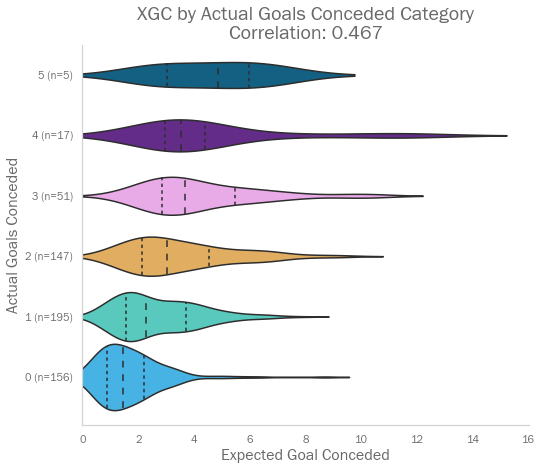

In [32]:
x = df_tm['XG']
y = df_tm['Goals']
n = [len(df_tm.loc[df_tm['Goals']==i]) for i in range(6)]

data = df_tm.loc[df_tm['Goals']<6]
corr = round(np.corrcoef(data['XG'],data['Goals'])[0][1],3)

plt.figure(figsize=(8,7))
sns.violinplot('XG','Goals', data=data,
               width=1.1, inner='quartile', orient='h')

plt.xlim(0)
plt.ylim(-0.8,5.5)

plt.yticks(range(6), [f'{i} (n={n[i]})' for i in range(6)])

plt.title(f'XGC by Actual Goals Conceded Category\nCorrelation: {corr}')
plt.xlabel('Expected Goal Conceded')
plt.ylabel('Actual Goals Conceded');

So, XGC is a pretty good indicator of goals conceded (this breaks down a bit after 3 goals, though by this point the sample sizes are small, and a clean sheet is basicallly out of the question anyway).

In [33]:
df_tm.reset_index(inplace=True)
df_tm.columns = ['GameWeek','Team','MatchID','GoalsConceded','XGC']
df_tm.head()

GameWeek                      Team  MatchID  GoalsConceded       XGC
0         1                   Arsenal    46614              0  0.996303
1         1               Aston Villa    46610              3  3.240594
2         1               Bournemouth    46606              1  2.588459
3         1  Brighton and Hove Albion    46611              0  2.450373
4         1                   Burnley    46607              0  2.658945

Let's get this data into our SQL database.

In [34]:
create_sql_table(df_tm, c, table_name = 'TeamsXGC', verbose=True)
conn.commit()

populate_sql_from_dataframe(df_tm, 'TeamsXGC', c, verbose=True)
conn.commit()

CREATE TABLE TeamsXGC (TeamsXGCID INTEGER PRIMARY KEY, TableIndex TEXT, GameWeek INTEGER, Team TEXT, MatchID INTEGER, GoalsConceded INTEGER, XGC REAL, unique (GameWeek, Team, MatchID, GoalsConceded, XGC));

Table not added - possibly already exists
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (0, 1, "Arsenal", 46614, 0, 0.9963027951445779);
                       
Error on row 0 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (1, 1, "Aston Villa", 46610, 3, 3.2405938769732603);
                       
Error on row 1 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (2, 1, "Bournemouth", 46606, 1, 2.5884591648907422);
                       
Error on row 2 - you may be trying to upload a duplicate row
INSERT INTO Te

                       
Error on row 64 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (65, 4, "Chelsea", 46637, 1, 0.8169813088764035);
                       
Error on row 65 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (66, 4, "Crystal Palace", 46638, 0, 0.7149828612153257);
                       
Error on row 66 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (67, 4, "Everton", 46639, 2, 5.487286311661945);
                       
Error on row 67 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (68, 4, "Leicester City", 46640, 1, 0.7429140183599574);
       

                       
Error on row 132 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (133, 7, "Norwich City", 46668, 2, 2.421063127210447);
                       
Error on row 133 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (134, 7, "Sheffield United", 46672, 1, 1.9640348548723399);
                       
Error on row 134 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (135, 7, "Southampton", 46673, 2, 3.8750538115144564);
                       
Error on row 135 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (136, 7, "Tottenham Hotspur", 46673, 1, 4.3125

                       
Error on row 193 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (194, 10, "Sheffield United", 46704, 1, 4.507536103890323);
                       
Error on row 194 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (195, 10, "Southampton", 46702, 9, 14.73578244458392);
                       
Error on row 195 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (196, 10, "Tottenham Hotspur", 46698, 2, 4.201979370915159);
                       
Error on row 196 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (197, 10, "Watford", 46703, 0, 2.9946991

INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (256, 13, "Tottenham Hotspur", 46734, 2, 3.558107549346449);
                       
Error on row 256 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (257, 13, "Watford", 46733, 3, 3.054255270092562);
                       
Error on row 257 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (258, 13, "West Ham United", 46734, 3, 4.569899605214892);
                       
Error on row 258 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (259, 13, "Wolverhampton Wanderers", 46727, 1, 2.2486387806089287);
                       
Error on row 259 - you may be trying to 

                       
Error on row 324 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (325, 17, "Chelsea", 46767, 1, 4.0446121570333196);
                       
Error on row 325 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (326, 17, "Crystal Palace", 46768, 1, 6.752106192584389);
                       
Error on row 326 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (327, 17, "Everton", 46771, 1, 2.3229634265440504);
                       
Error on row 327 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (328, 17, "Leicester City", 46769, 1, 3.71174252566248

                       
Error on row 381 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (382, 20, "Burnley", 46797, 2, 2.111042843389815);
                       
Error on row 382 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (383, 20, "Chelsea", 46795, 1, 1.3430696839038236);
                       
Error on row 383 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (384, 20, "Crystal Palace", 46802, 1, 3.8384949273485858);
                       
Error on row 384 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (385, 20, "Everton", 46800, 1, 3.0632615904371754);
  

Error on row 451 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (452, 23, "Sheffield United", 46825, 1, 1.689590982164347);
                       
Error on row 452 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (453, 23, "Southampton", 46832, 3, 2.859541903819372);
                       
Error on row 453 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (454, 23, "Tottenham Hotspur", 46833, 0, 2.3782199250327256);
                       
Error on row 454 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (455, 23, "Watford", 46833, 0, 2.6152353736103806);
           

Error on row 520 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (521, 27, "Aston Villa", 46873, 2, 3.7691579605101766);
                       
Error on row 521 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (522, 27, "Bournemouth", 46866, 3, 3.5119305060353927);
                       
Error on row 522 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (523, 27, "Brighton and Hove Albion", 46872, 1, 2.3203083598225698);
                       
Error on row 523 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (524, 27, "Burnley", 46866, 0, 1.9922158870814402);
       

In [47]:
#Sum all the teams' goals against, and XG against
df_tm_for = df_pm.groupby(['GameWeek','ForTeam','MatchID']).sum()[['XG']]
df_tm_against = df_pm.groupby(['GameWeek','AgainstTeam','MatchID']).sum()[['XG']]
df_tm_against.columns = ['XGC']
df_txg = pd.concat([df_tm_for, df_tm_against], axis=1).reset_index()
df_txg.head()

GameWeek                   ForTeam  MatchID        XG       XGC
0         1                   Arsenal    46614  1.249386  0.996303
1         1               Aston Villa    46610  1.448371  3.240594
2         1               Bournemouth    46606  4.023957  2.588459
3         1  Brighton and Hove Albion    46611  1.915772  2.450373
4         1                   Burnley    46607  3.973459  2.658945

In [48]:
create_sql_table(df_txg, c, table_name = 'TeamsXG', verbose=True)
conn.commit()

populate_sql_from_dataframe(df_txg, 'TeamsXG', c, verbose=True)
conn.commit()

CREATE TABLE TeamsXG (TeamsXGID INTEGER PRIMARY KEY, TableIndex TEXT, GameWeek INTEGER, ForTeam TEXT, MatchID INTEGER, XG REAL, XGC REAL, unique (GameWeek, ForTeam, MatchID, XG, XGC));

New table added
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (0, 1, "Arsenal", 46614, 1.2493858592148255, 0.9963027951445779);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (1, 1, "Aston Villa", 46610, 1.4483714426137015, 3.2405938769732603);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (2, 1, "Bournemouth", 46606, 4.023956891034905, 2.5884591648907422);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (3, 1, "Brighton and Hove Albion", 46611, 1.915771975339457, 2.4503727768395547);
                       
INSERT INTO Tea

INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (42, 3, "Bournemouth", 46626, 6.594392207462742, 7.3037909754567565);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (43, 3, "Brighton and Hove Albion", 46627, 3.1659477126837325, 4.007309782949907);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (44, 3, "Burnley", 46634, 3.418705924033077, 4.256798843883482);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (45, 3, "Chelsea", 46630, 2.9381761258748247, 1.6386792244293202);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (46, 3, "Crystal Palace", 46629, 1.2206476583827102, 2.8179062339361494);
                       
INSERT INTO TeamsXG (

INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (141, 8, "Aston Villa", 46681, 4.854232194281595, 3.8440285605259796);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (142, 8, "Bournemouth", 46675, 1.132454404884152, 3.171465155518899);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (143, 8, "Brighton and Hove Albion", 46676, 6.475373892769861, 2.2005210597714586);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (144, 8, "Burnley", 46677, 1.6010691016907108, 1.5567461714830335);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (145, 8, "Chelsea", 46682, 3.740795473633667, 2.6724143523819643);
                       
INSERT INTO TeamsXG 

INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (244, 13, "Burnley", 46733, 3.054255270092562, 1.699386194869832);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (245, 13, "Chelsea", 46731, 1.4713554940439382, 1.319258108433155);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (246, 13, "Crystal Palace", 46729, 1.8675108389768966, 2.7182342426304045);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (247, 13, "Everton", 46730, 1.782396158989594, 2.3528256592874763);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (248, 13, "Leicester City", 46728, 3.8844149882812813, 0.7604776745835329);
                       
INSERT INTO TeamsXG (Tabl

INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (347, 18, "Everton", 46778, 0.4700511552300217, 1.1396412986479405);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (348, 18, "Leicester City", 46779, 1.1659937492919363, 10.301291564772827);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (349, 18, "Manchester City", 46779, 10.301291564772827, 1.1659937492919363);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (350, 18, "Manchester United", 46783, 2.213924881710025, 2.180244462934925);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (351, 18, "Newcastle United", 46780, 1.2800656178310896, 1.9342607200917394);
                       
INS

INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (450, 23, "Newcastle United", 46830, 0.665575836776735, 1.8715092156071882);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (451, 23, "Norwich City", 46831, 5.276205403496718, 2.520903915306538);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (452, 23, "Sheffield United", 46825, 1.5364745520015537, 1.689590982164347);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (453, 23, "Southampton", 46832, 1.5752144671665134, 2.859541903819372);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (454, 23, "Tottenham Hotspur", 46833, 2.6152353736103806, 2.3782199250327256);
                       
INS

INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (552, 28, "Tottenham Hotspur", 46882, 10.424860430936242, 10.812907424545758);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (553, 28, "Watford", 46883, 2.651900524081579, 0.7457002456705657);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (554, 28, "West Ham United", 46884, 11.273493399493788, 4.413744446357347);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (555, 28, "Wolverhampton Wanderers", 46882, 10.812907424545758, 10.424860430936242);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (556, 29, "Arsenal", 46885, 1.1594974972935683, 2.2795329670474715);
                       
INS